In [4]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

import shap

%config InlineBackend.figure_format = 'retina'

In [69]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [9]:
os.getcwd()

'/Users/nicolasschroeder/DSB/Semester 2/ML2/Final Project/tuning_results/tuning_xgb/202403201655'

In [10]:
df = pd.read_csv('../../../Data/cover_type_engineered.csv')

In [11]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
# df = df.loc[(df['Cover_Type'] == 1) | (df['Cover_Type'] == 2)]

X = df.drop(columns=['Cover_Type', 'Aspect_Sector', 'rolling_mean_elevation', 'exp_elevation'])
y_train = df['Cover_Type'] - 1

In [12]:
y_train.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [13]:
X = X.loc[:, [col for col in X if not col.startswith('Soil_Type')]]

In [14]:
X = X[['Wilderness_Area3',
 'Hillshade_Noon',
 'elevation_bin',
 'Euclidian_Distance',
 'Horizontal_Distance_To_Roadways',
 'Wilderness_Area4',
 'Vertical_Distance_To_Hydrology',
 'Elevation',
 'sqrt_elevation',
 'subalpine',
 'Wilderness_Area2',
 'Aspect_Sector_NW',
 'Diff_Noon_3pm',
 'igneous_and_metamorphic',
 'montane',
 'alpine',
 'Wilderness_Area1',
 'log_elevation',
 'reciprocal_elevation',
 'Horizontal_Distance_To_Fire_Points',
 'elevation_squared',
 'montane_and_subalpine',
 'elevation_cubed',
 'glacial',
 'lower_montane',
 'Id',
 'Hillshade_9am',
 'Horizontal_Distance_To_Hydrology']]

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the estimator
estimator = XGBClassifier(tree_method="hist")

# Define hyperparameters for tuning
hyperparameters = {
    "n_estimators": stats.randint(50, 150),  # Increased range
    "learning_rate": stats.uniform(0.05, 0.1),  # Adjusted range
    "colsample_bytree": stats.uniform(0.6, 0.4),
    "colsample_bylevel": stats.uniform(0.6, 0.4),
    "colsample_bynode": stats.uniform(0.6, 0.4),
    "max_depth": stats.randint(15, 50),  # Increased range
    "subsample": stats.uniform(0.6, 0.4),
    "gamma": stats.uniform(0, 2),  # Adjusted range
    "reg_lambda": stats.uniform(0, 2),  # Adjusted range
    "reg_alpha": stats.uniform(0, 2),  # Adjusted range
}

# Define the RandomizedSearchCV parameters
random_search = RandomizedSearchCV(estimator, 
                                   param_distributions=hyperparameters, 
                                   scoring='accuracy',
                                   return_train_score=True,
                                   n_iter=100, 
                                   cv=5, 
                                   verbose=10, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"./tuning_results/tuning_xgb/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"xgb_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
        

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5; 1/100] START colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608
[CV 3/5; 1/100] END colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608;, score=(train=0.939, test=0.860) total time=   2.0s
[CV 1/5; 3/100] START colsample_bylevel=0.947687914207515, colsample_bynode=0.8644739759610502, colsample_bytree=0.6008620802397907, gamma=1.7028237283012484, learning_rate=0.0615981632830771, max_depth=36, n_estimators=133, reg_alpha=0.714311676959448, re

[CV 5/5; 1/100] START colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608
[CV 5/5; 1/100] END colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608;, score=(train=0.940, test=0.857) total time=   2.0s
[CV 3/5; 3/100] START colsample_bylevel=0.947687914207515, colsample_bynode=0.8644739759610502, colsample_bytree=0.6008620802397907, gamma=1.7028237283012484, learning_rate=0.0615981632830771, max_depth=36, n_estimators=133, reg_alpha=0.714311676959448, reg_lambda=1.1485127663805343, subsample=0.8364975170370567
[CV 3

[CV 2/5; 2/100] START colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148
[CV 2/5; 2/100] END colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148;, score=(train=0.914, test=0.851) total time=   2.1s
[CV 4/5; 3/100] START colsample_bylevel=0.947687914207515, colsample_bynode=0.8644739759610502, colsample_bytree=0.6008620802397907, gamma=1.7028237283012484, learning_rate=0.0615981632830771, max_depth=36, n_estimators=133, reg_alpha=0.714311676959448, reg_lambda=1.1485127663805343, subsample=0.8364975170370567
[CV 4/5; 

[CV 4/5; 1/100] START colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608
[CV 4/5; 1/100] END colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608;, score=(train=0.938, test=0.870) total time=   2.0s
[CV 5/5; 2/100] START colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148
[CV 5/

[CV 2/5; 1/100] START colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608
[CV 2/5; 1/100] END colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608;, score=(train=0.937, test=0.872) total time=   2.0s
[CV 2/5; 3/100] START colsample_bylevel=0.947687914207515, colsample_bynode=0.8644739759610502, colsample_bytree=0.6008620802397907, gamma=1.7028237283012484, learning_rate=0.0615981632830771, max_depth=36, n_estimators=133, reg_alpha=0.714311676959448, reg_lambda=1.1485127663805343, subsample=0.8364975170370567
[CV 2

[CV 1/5; 2/100] START colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148
[CV 1/5; 2/100] END colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148;, score=(train=0.916, test=0.851) total time=   2.1s
[CV 1/5; 4/100] START colsample_bylevel=0.9795646728705797, colsample_bynode=0.9105810361584719, colsample_bytree=0.9543836564965038, gamma=1.84680668316894, learning_rate=0.08510699711407896, max_depth=32, n_estimators=50, reg_alpha=0.8595069706744354, reg_lambda=1.0775435826292183, subsample=0.7423147307121407
[CV 1/5; 

[CV 3/5; 2/100] START colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148
[CV 3/5; 2/100] END colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148;, score=(train=0.915, test=0.846) total time=   2.1s
[CV 5/5; 3/100] START colsample_bylevel=0.947687914207515, colsample_bynode=0.8644739759610502, colsample_bytree=0.6008620802397907, gamma=1.7028237283012484, learning_rate=0.0615981632830771, max_depth=36, n_estimators=133, reg_alpha=0.714311676959448, reg_lambda=1.1485127663805343, subsample=0.8364975170370567
[CV 5/5; 

[CV 1/5; 1/100] START colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608
[CV 1/5; 1/100] END colsample_bylevel=0.965866658131705, colsample_bynode=0.7501737417079617, colsample_bytree=0.6092088032688446, gamma=1.0362054522887276, learning_rate=0.08079843918731157, max_depth=28, n_estimators=86, reg_alpha=0.5097544679840338, reg_lambda=1.1250180071902922, subsample=0.6361128185449608;, score=(train=0.939, test=0.863) total time=   2.0s
[CV 4/5; 2/100] START colsample_bylevel=0.61663987300888, colsample_bynode=0.6455926666911286, colsample_bytree=0.8577663891412668, gamma=0.6160943549320554, learning_rate=0.06116042418557299, max_depth=43, n_estimators=88, reg_alpha=1.674607440177378, reg_lambda=1.6783679999698058, subsample=0.6474235164029148
[CV 4/

In [16]:
cv_results.head()

NameError: name 'cv_results' is not defined

In [3]:
results_path = f"./tuning_results/tuning_xgb/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

NameError: name 'os' is not defined

# CV Evaluation

In [ ]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

In [ ]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

In [ ]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Validation Score")

plt.grid()
plt.xlabel('Sorted Validation Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [ ]:
print(f"Mean Train Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Validation Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

In [19]:
file_name = f"xgb_{timestamp}.pkl"
random_search = pickle.load(open(os.path.join(file_name), "rb"))
model = random_search.best_estimator_

#model = XGBClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
# y_test_prediction = model.predict(X_test)

In [20]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
# print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

Train set, Accuracy = 1.00


In [21]:
# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = {feature_name: importance_score for feature_name, importance_score in zip(X.columns, feature_importance)}

# Sort the dictionary by importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 features
top_features = sorted_feature_importance[:10]

features = [i[0] for i in top_features]
importance = [i[1] for i in top_features]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(10), importance, align='center')
plt.yticks(range(10), features)
plt.title('Feature Importance XGB')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

NameError: name 'feature_importance' is not defined

In the context of XGBoost, these scores are often computed based on the following:

- Weight: The number of times a feature appears in a tree across the ensemble of trees.
- Gain: The average gain of a feature when it is used in trees.
- Cover: The average coverage of a feature when it is used in trees.

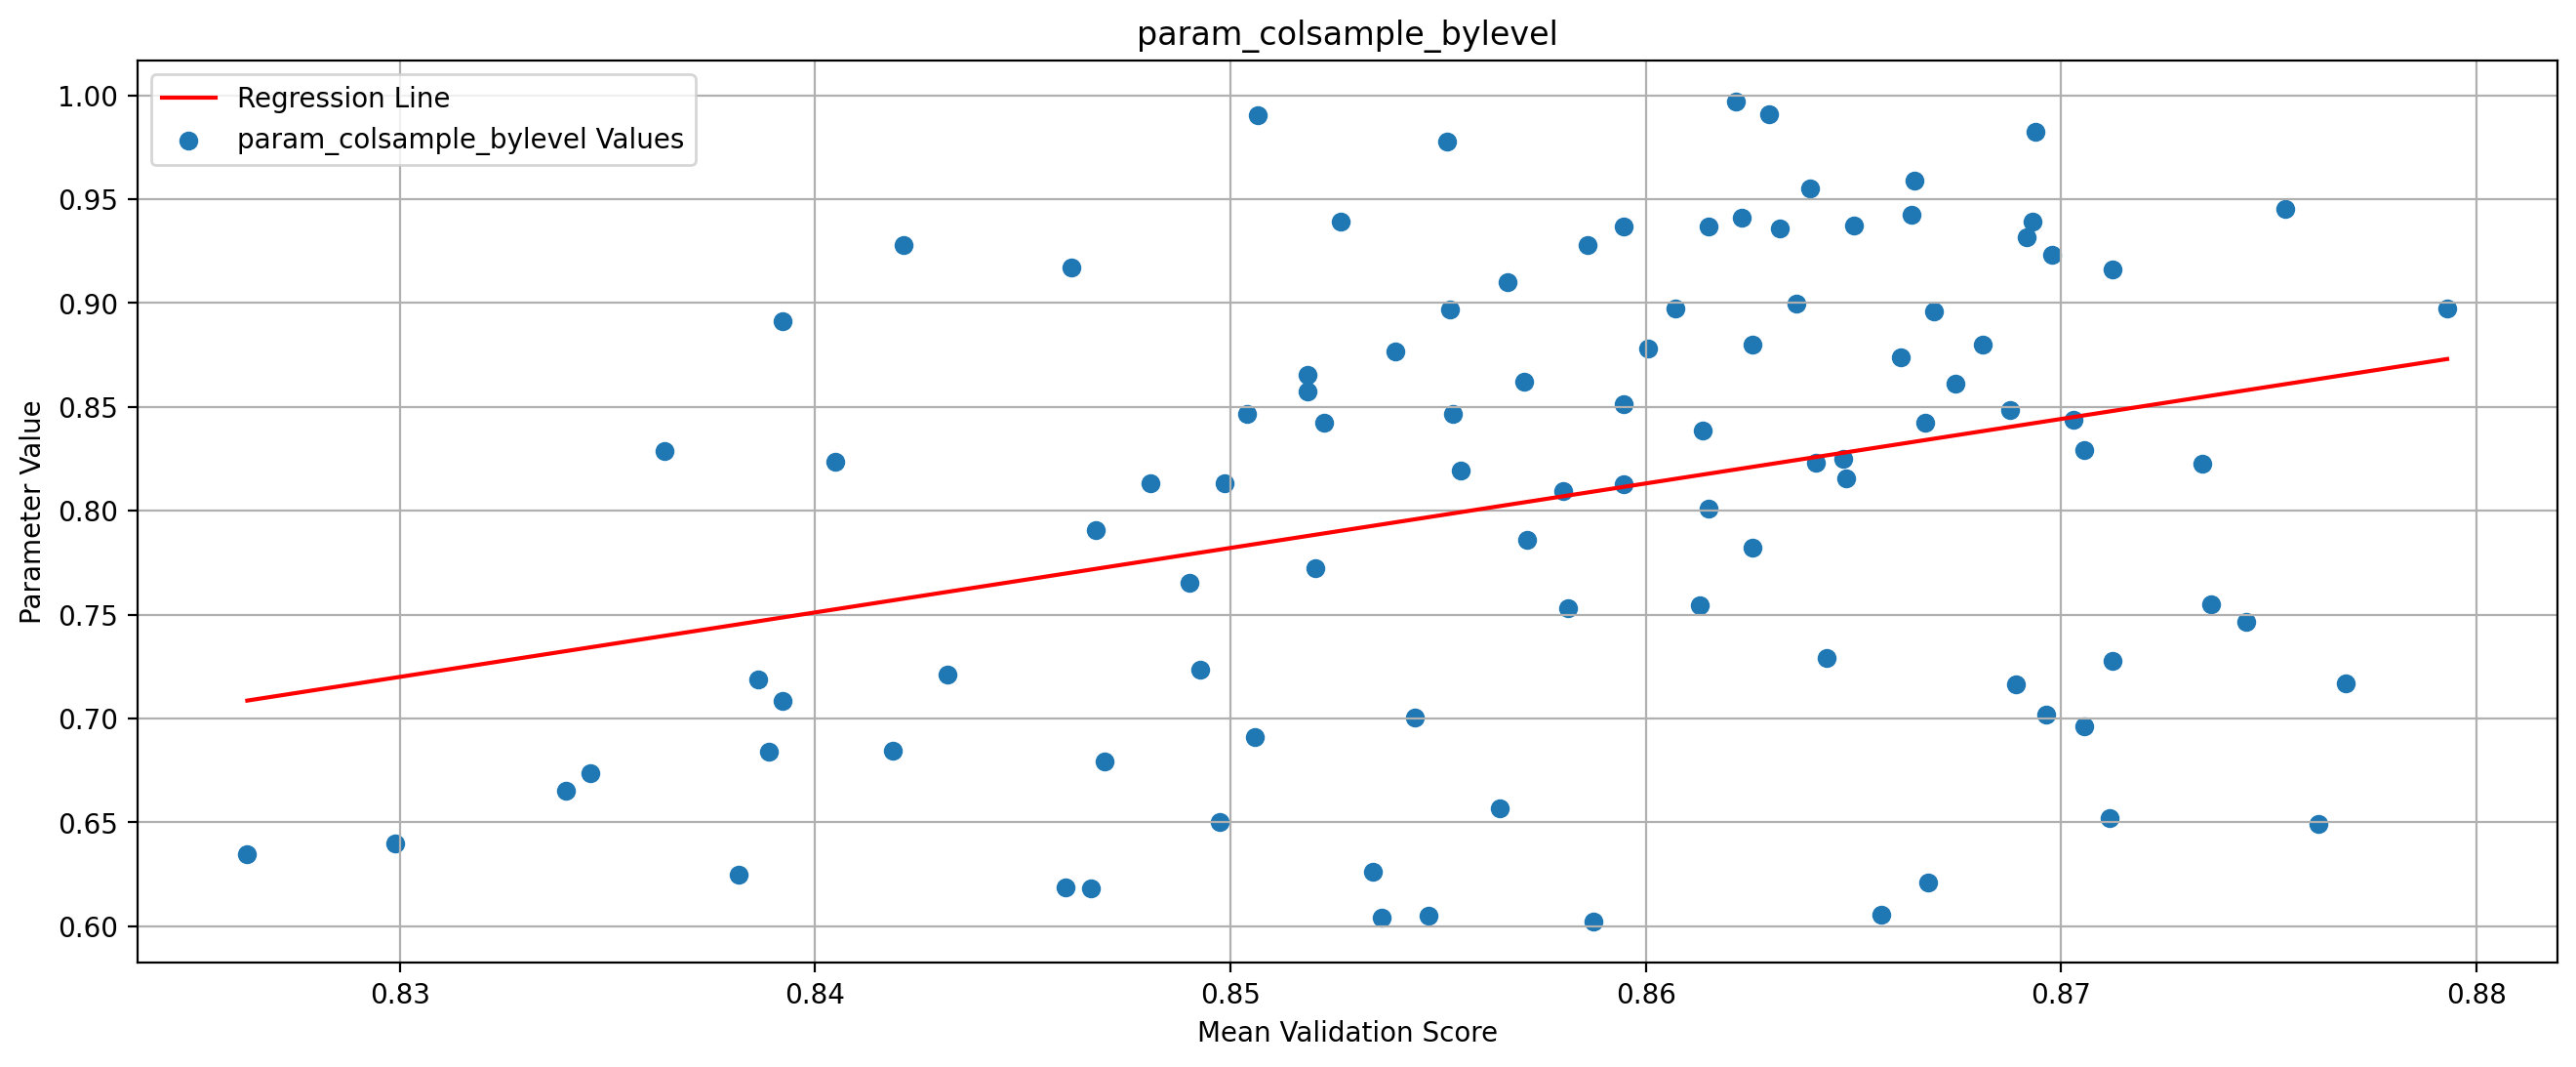

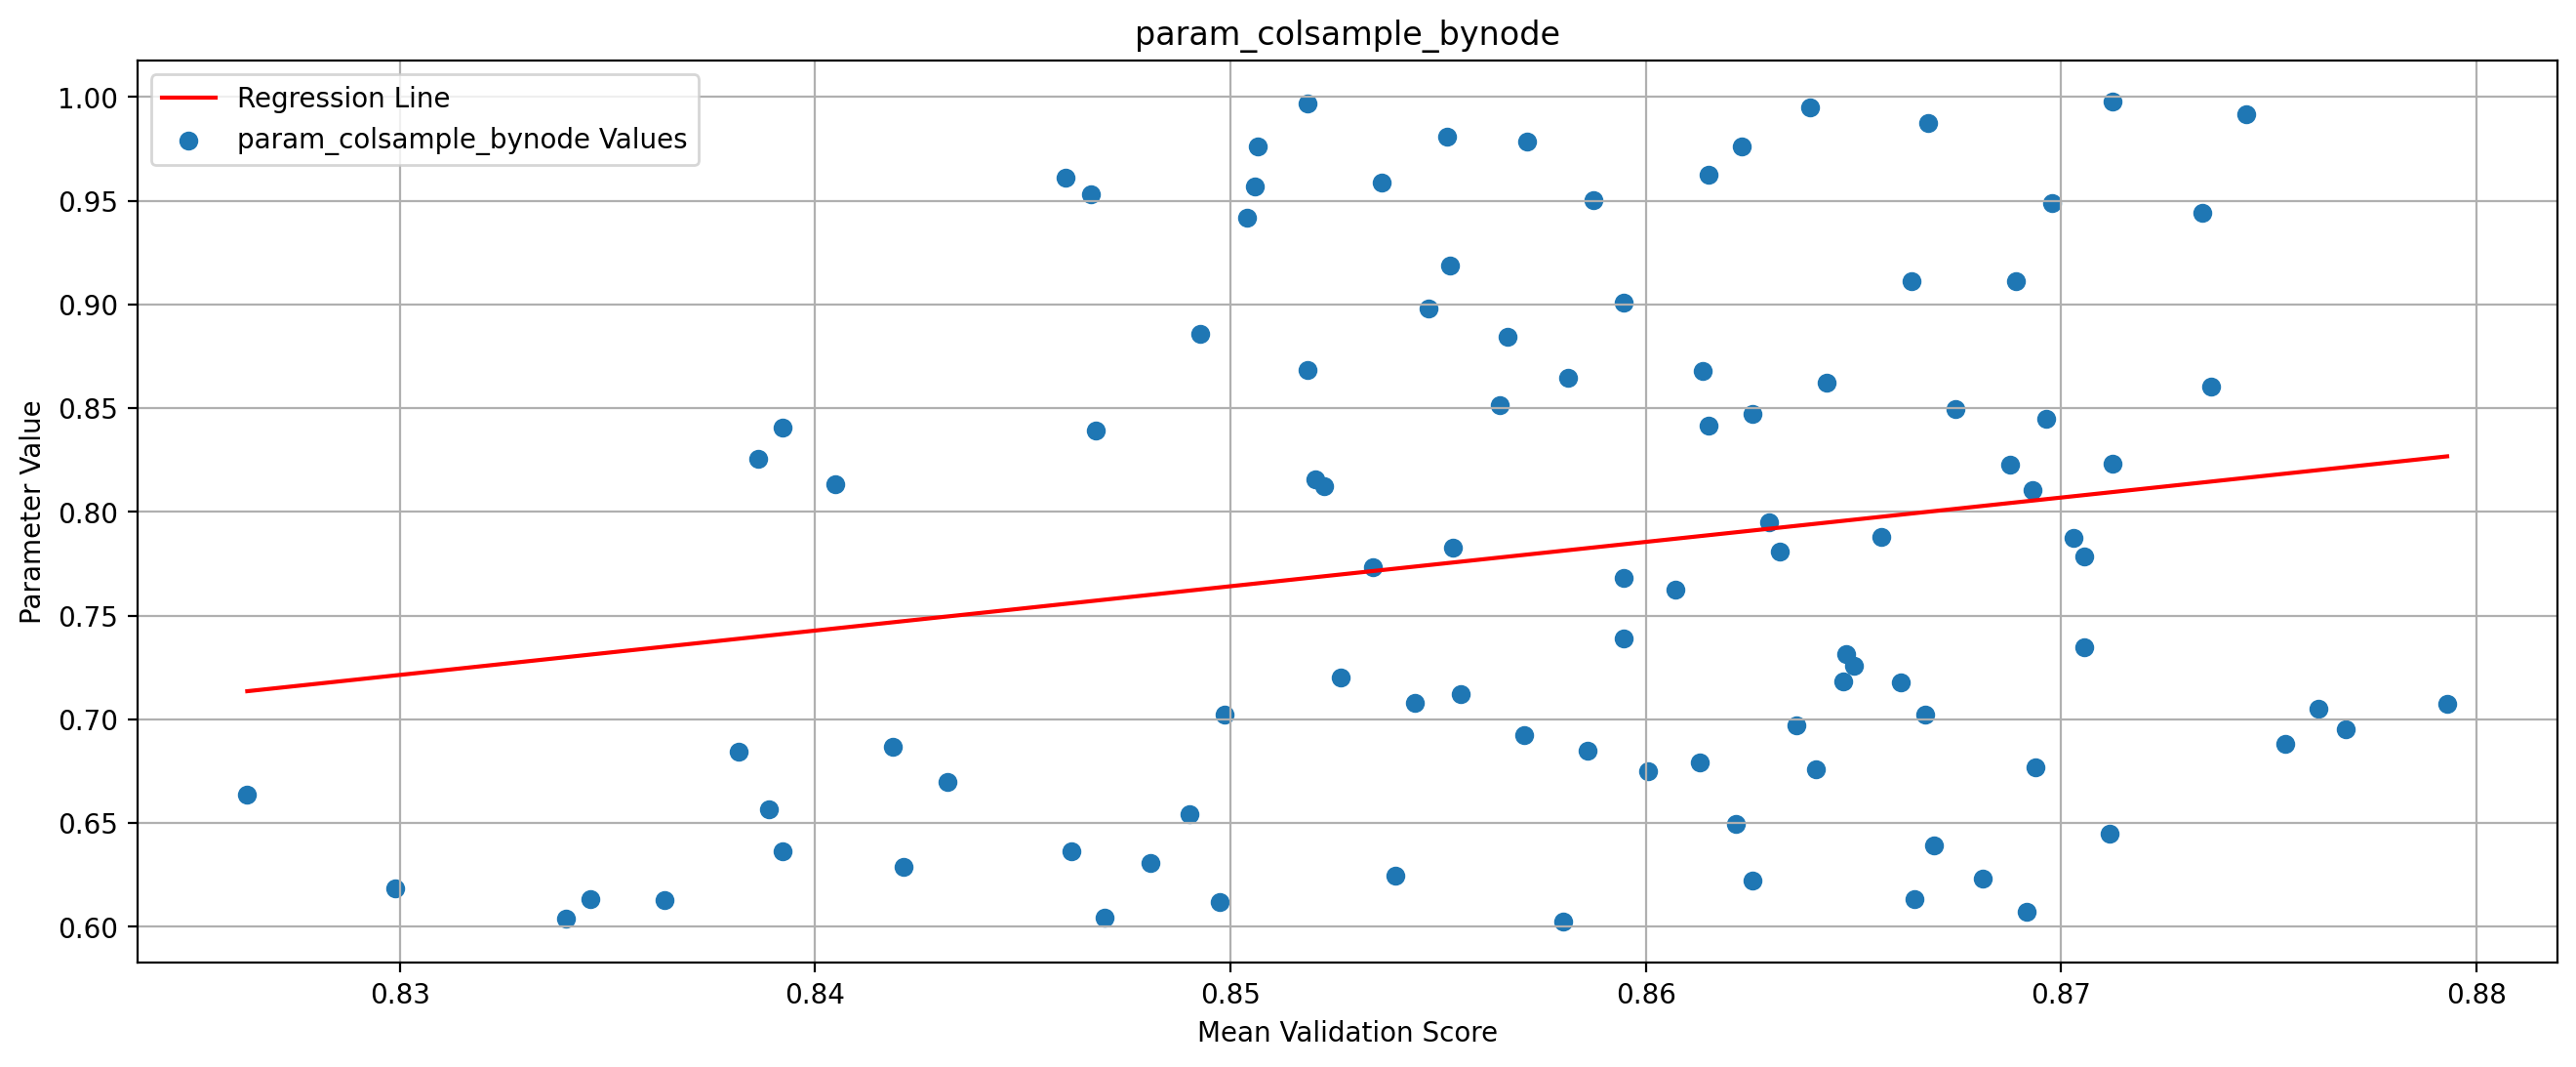

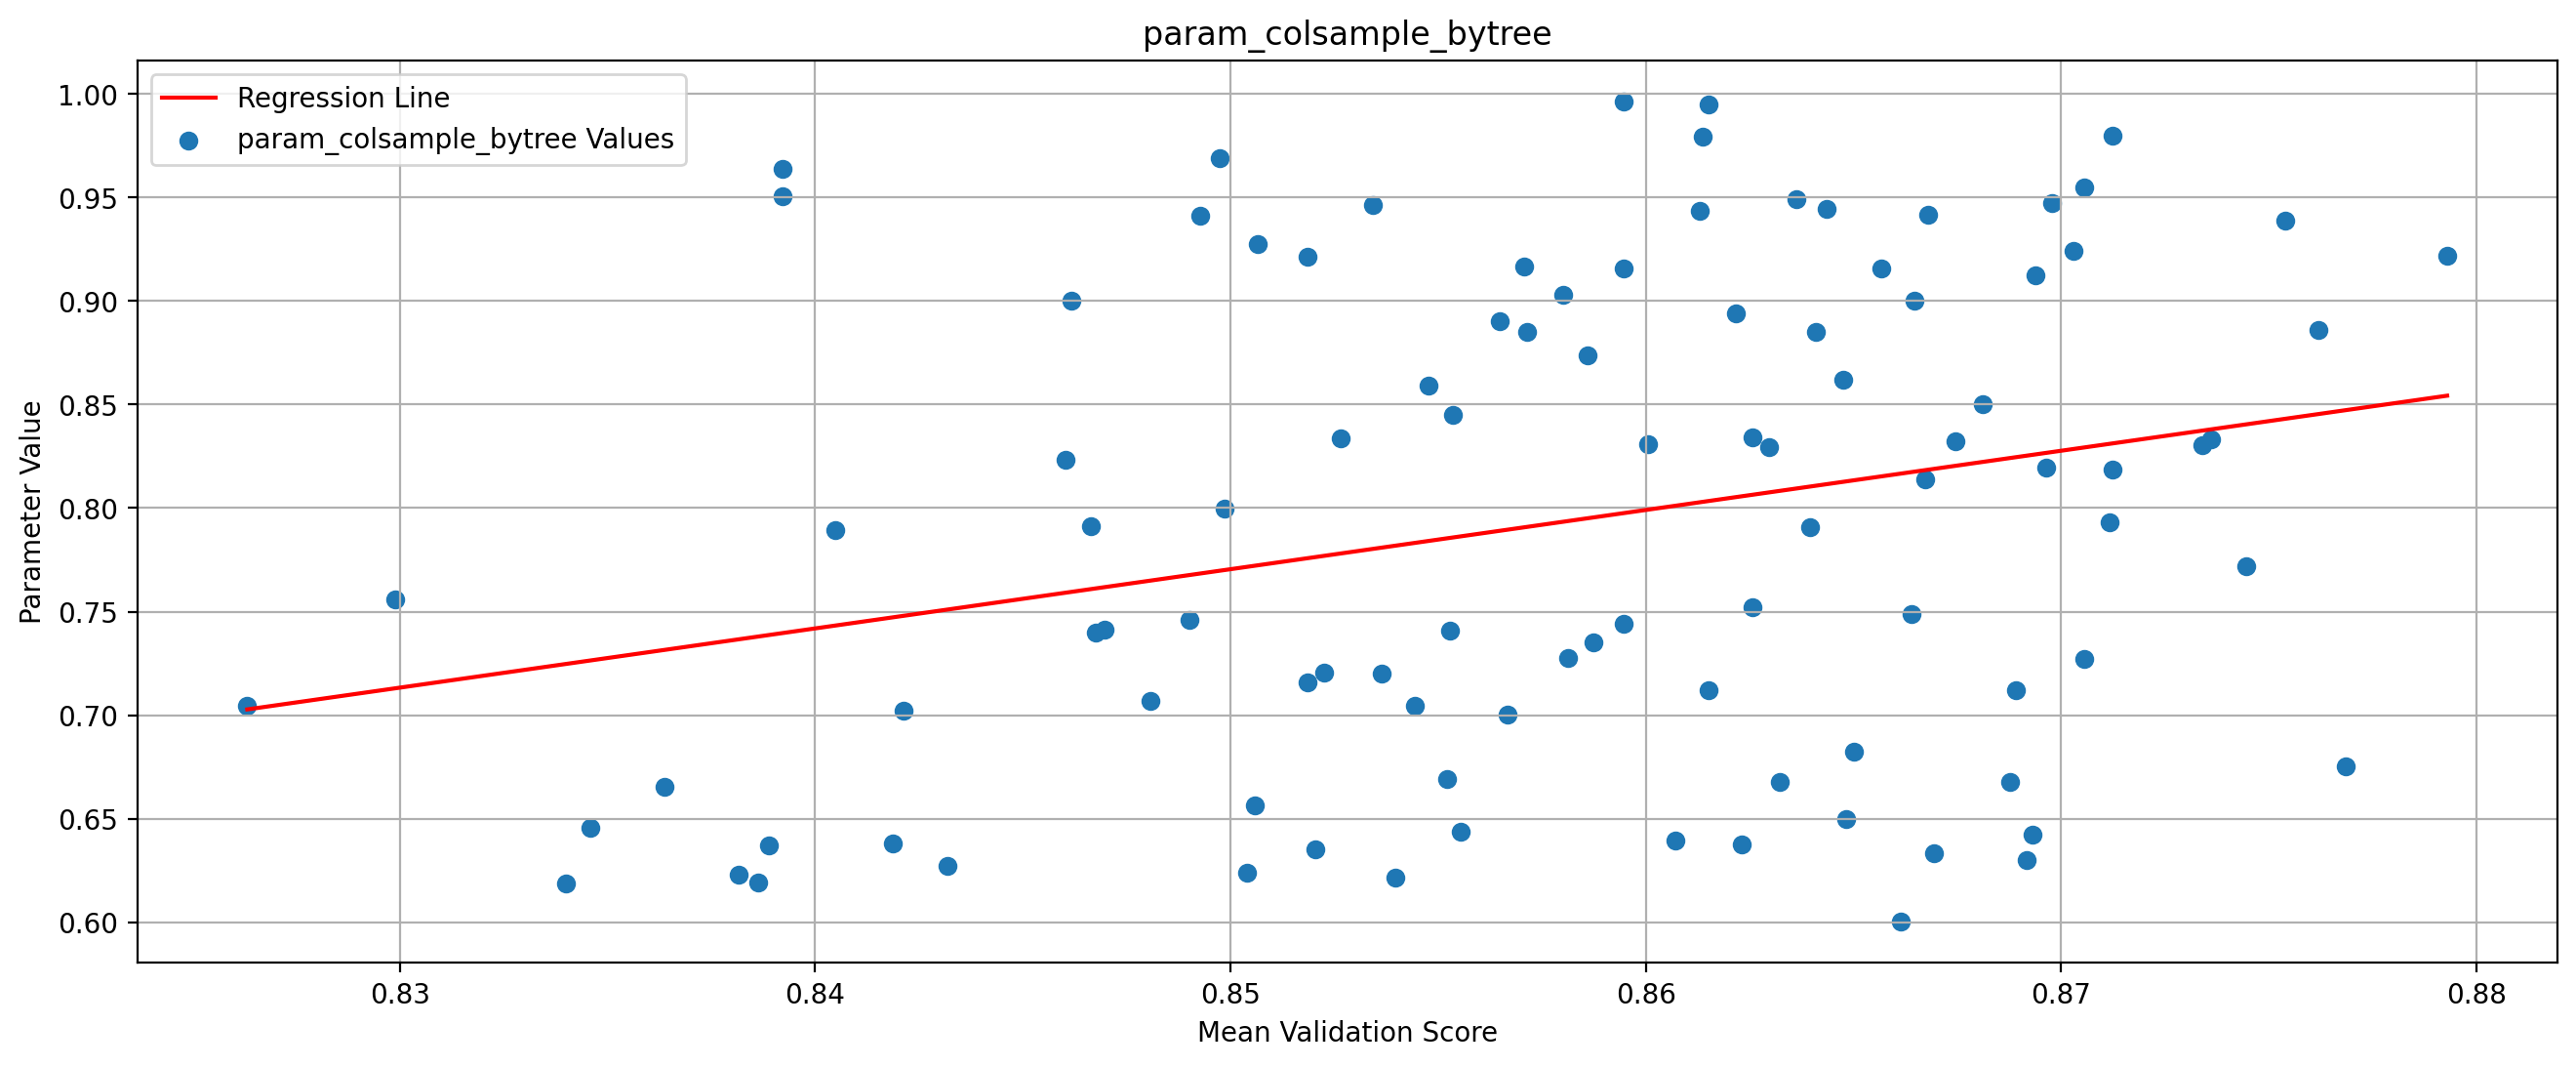

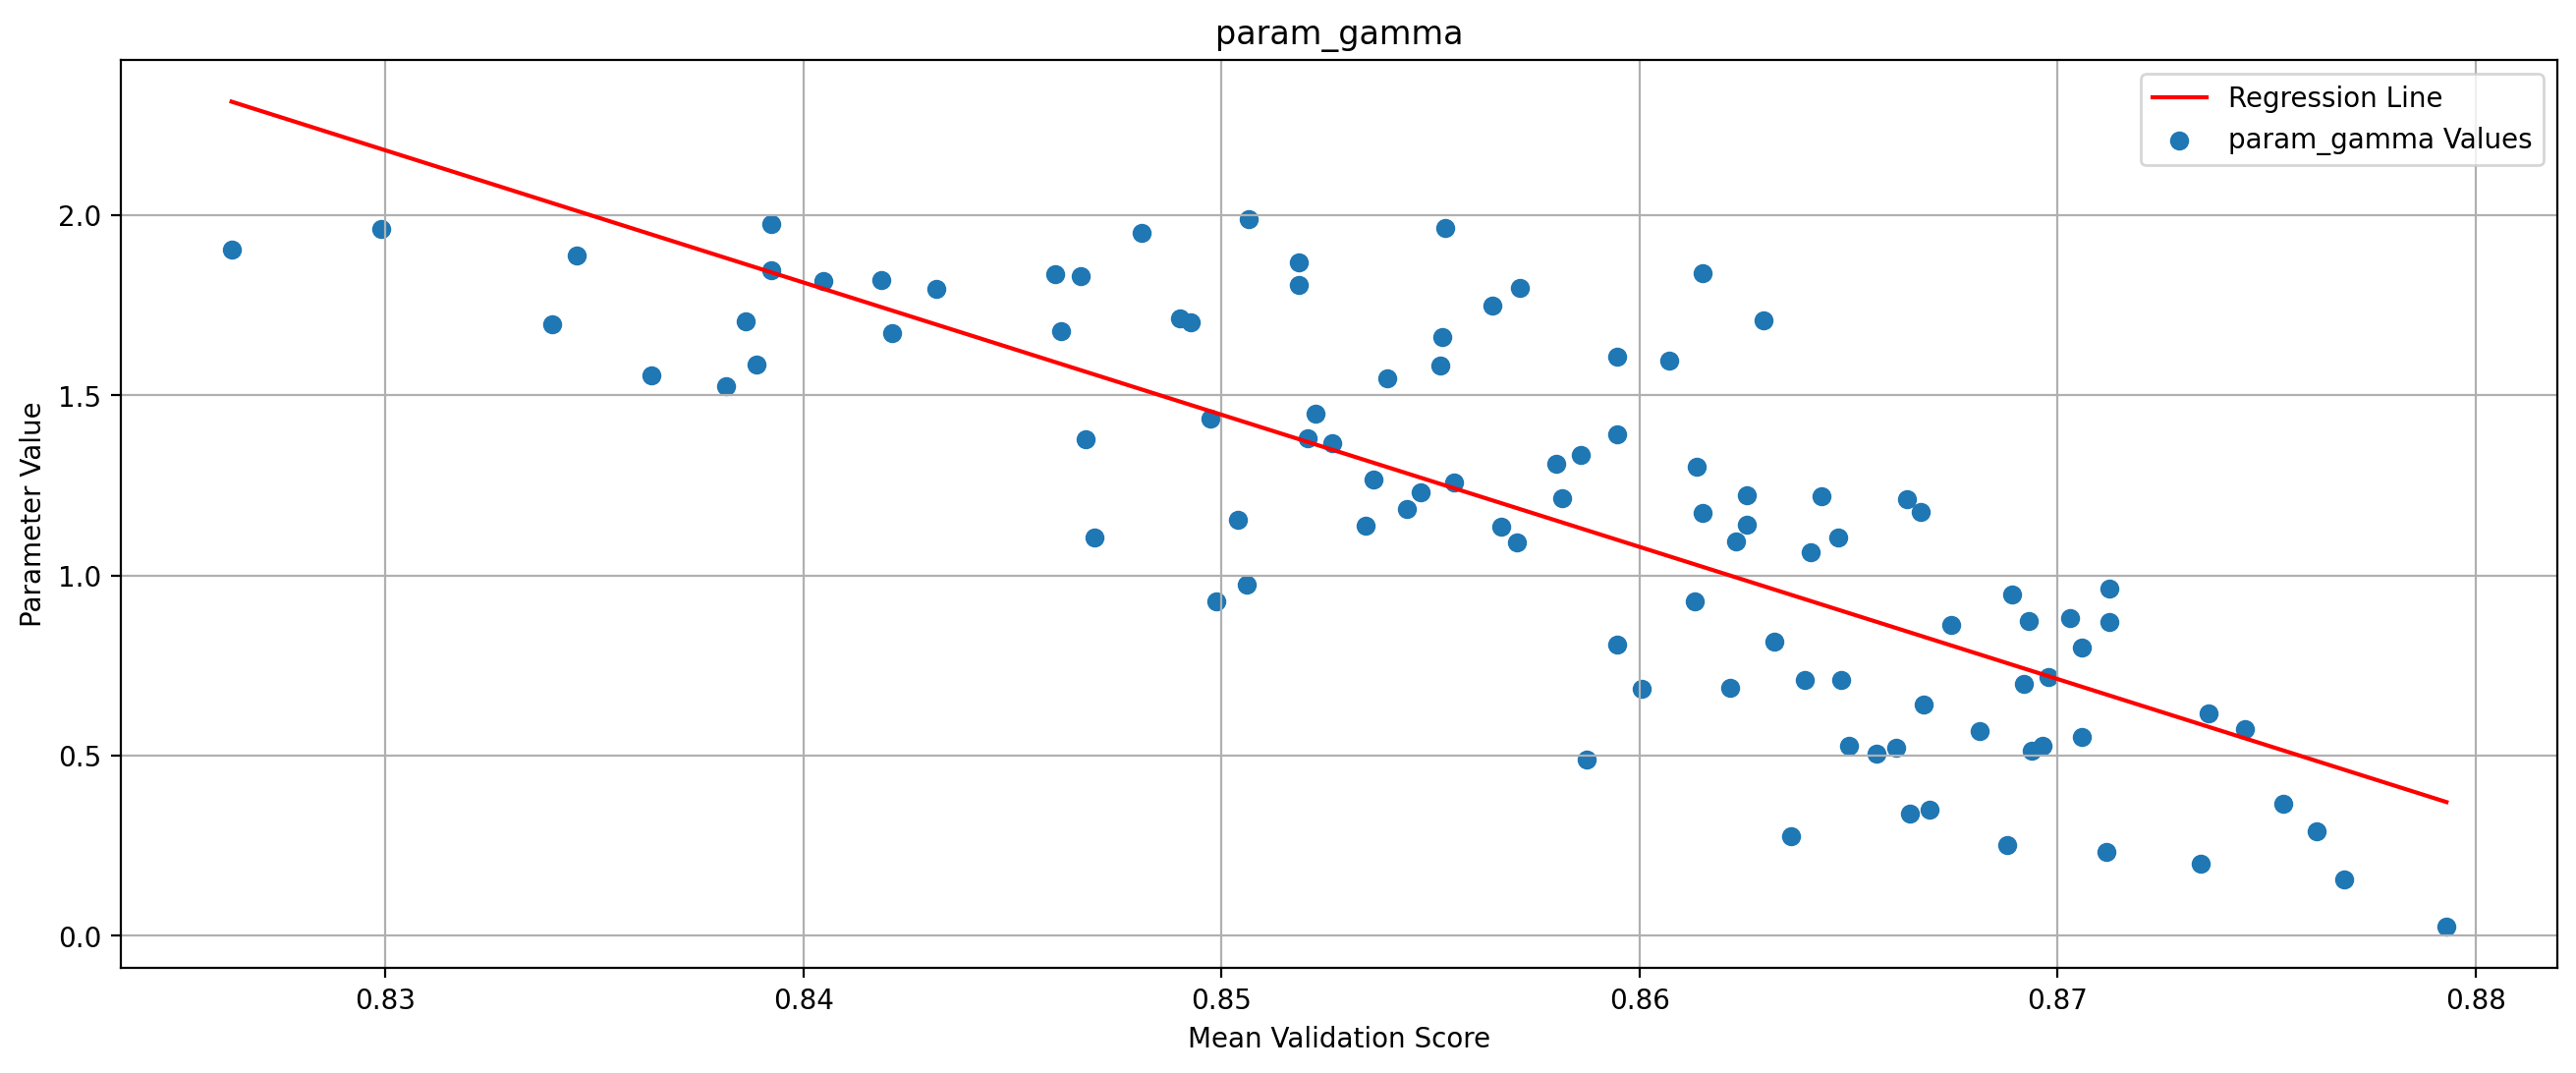

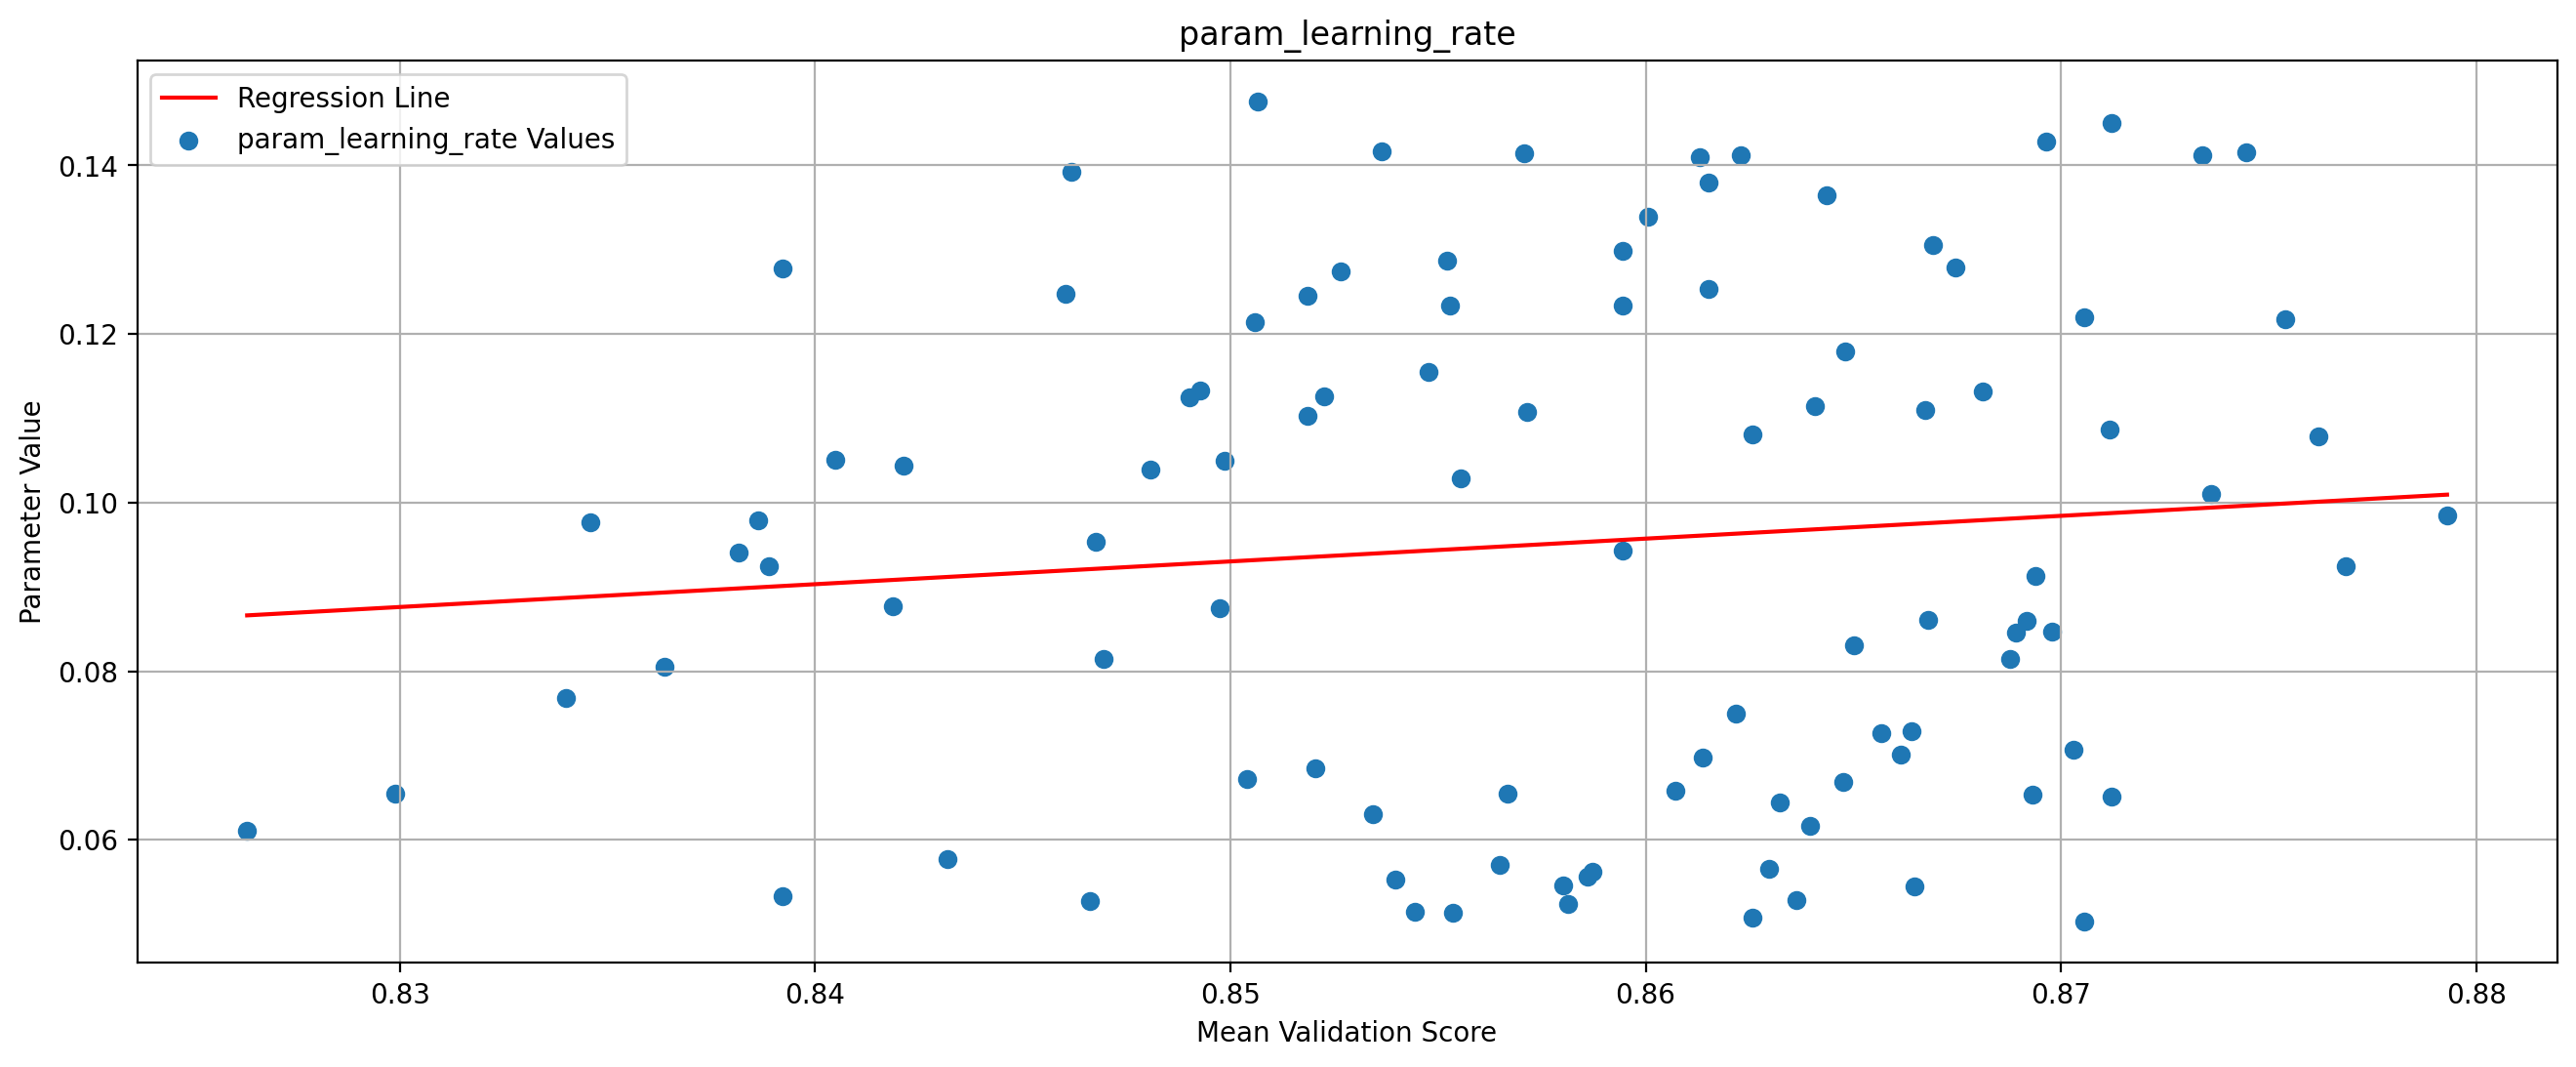

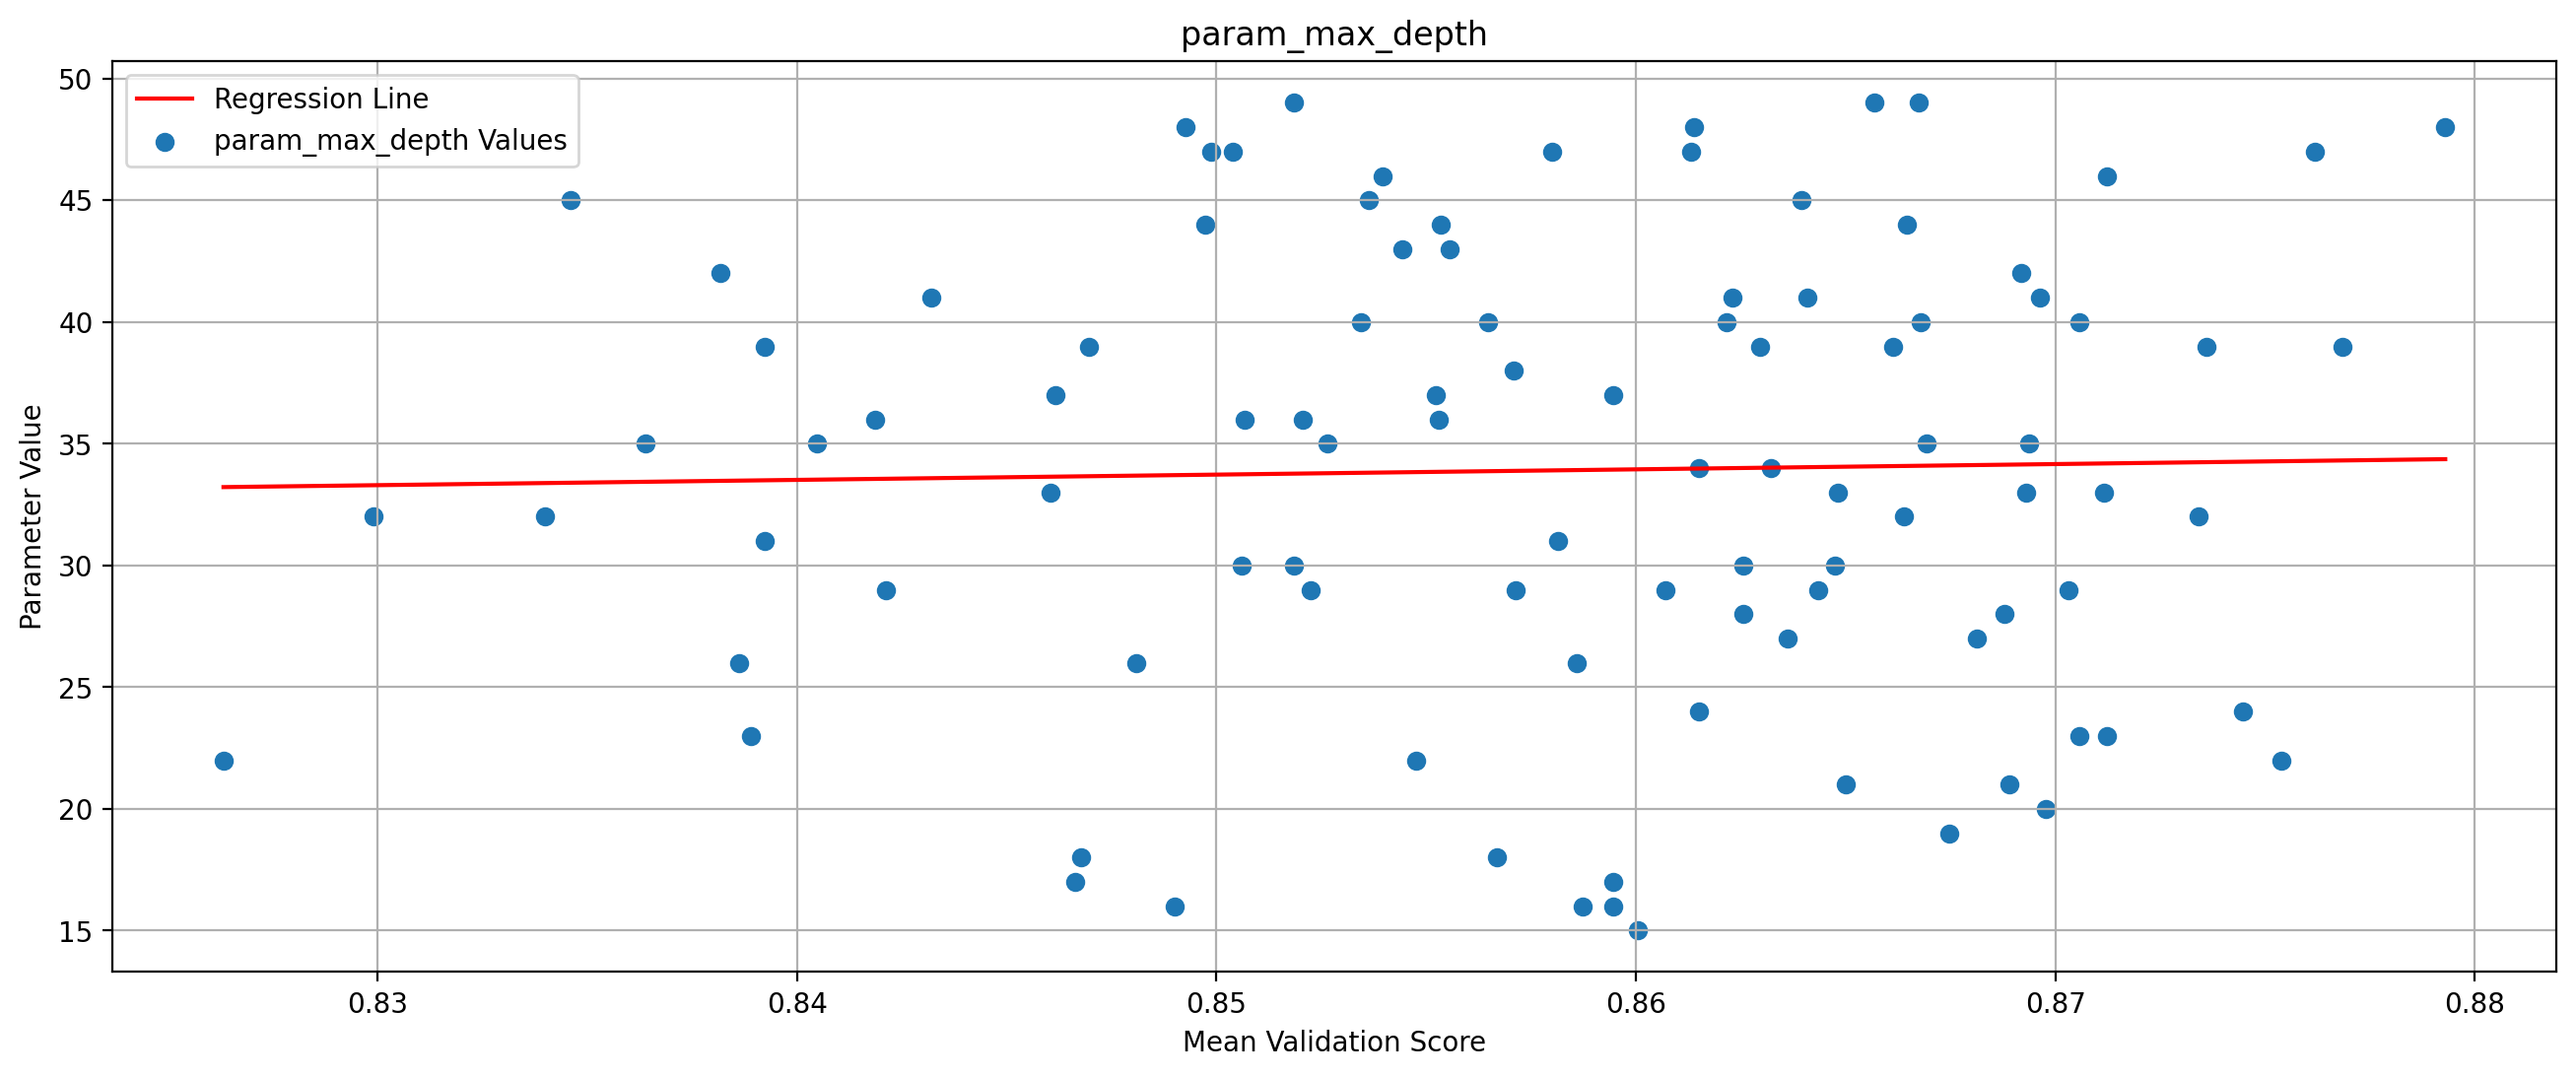

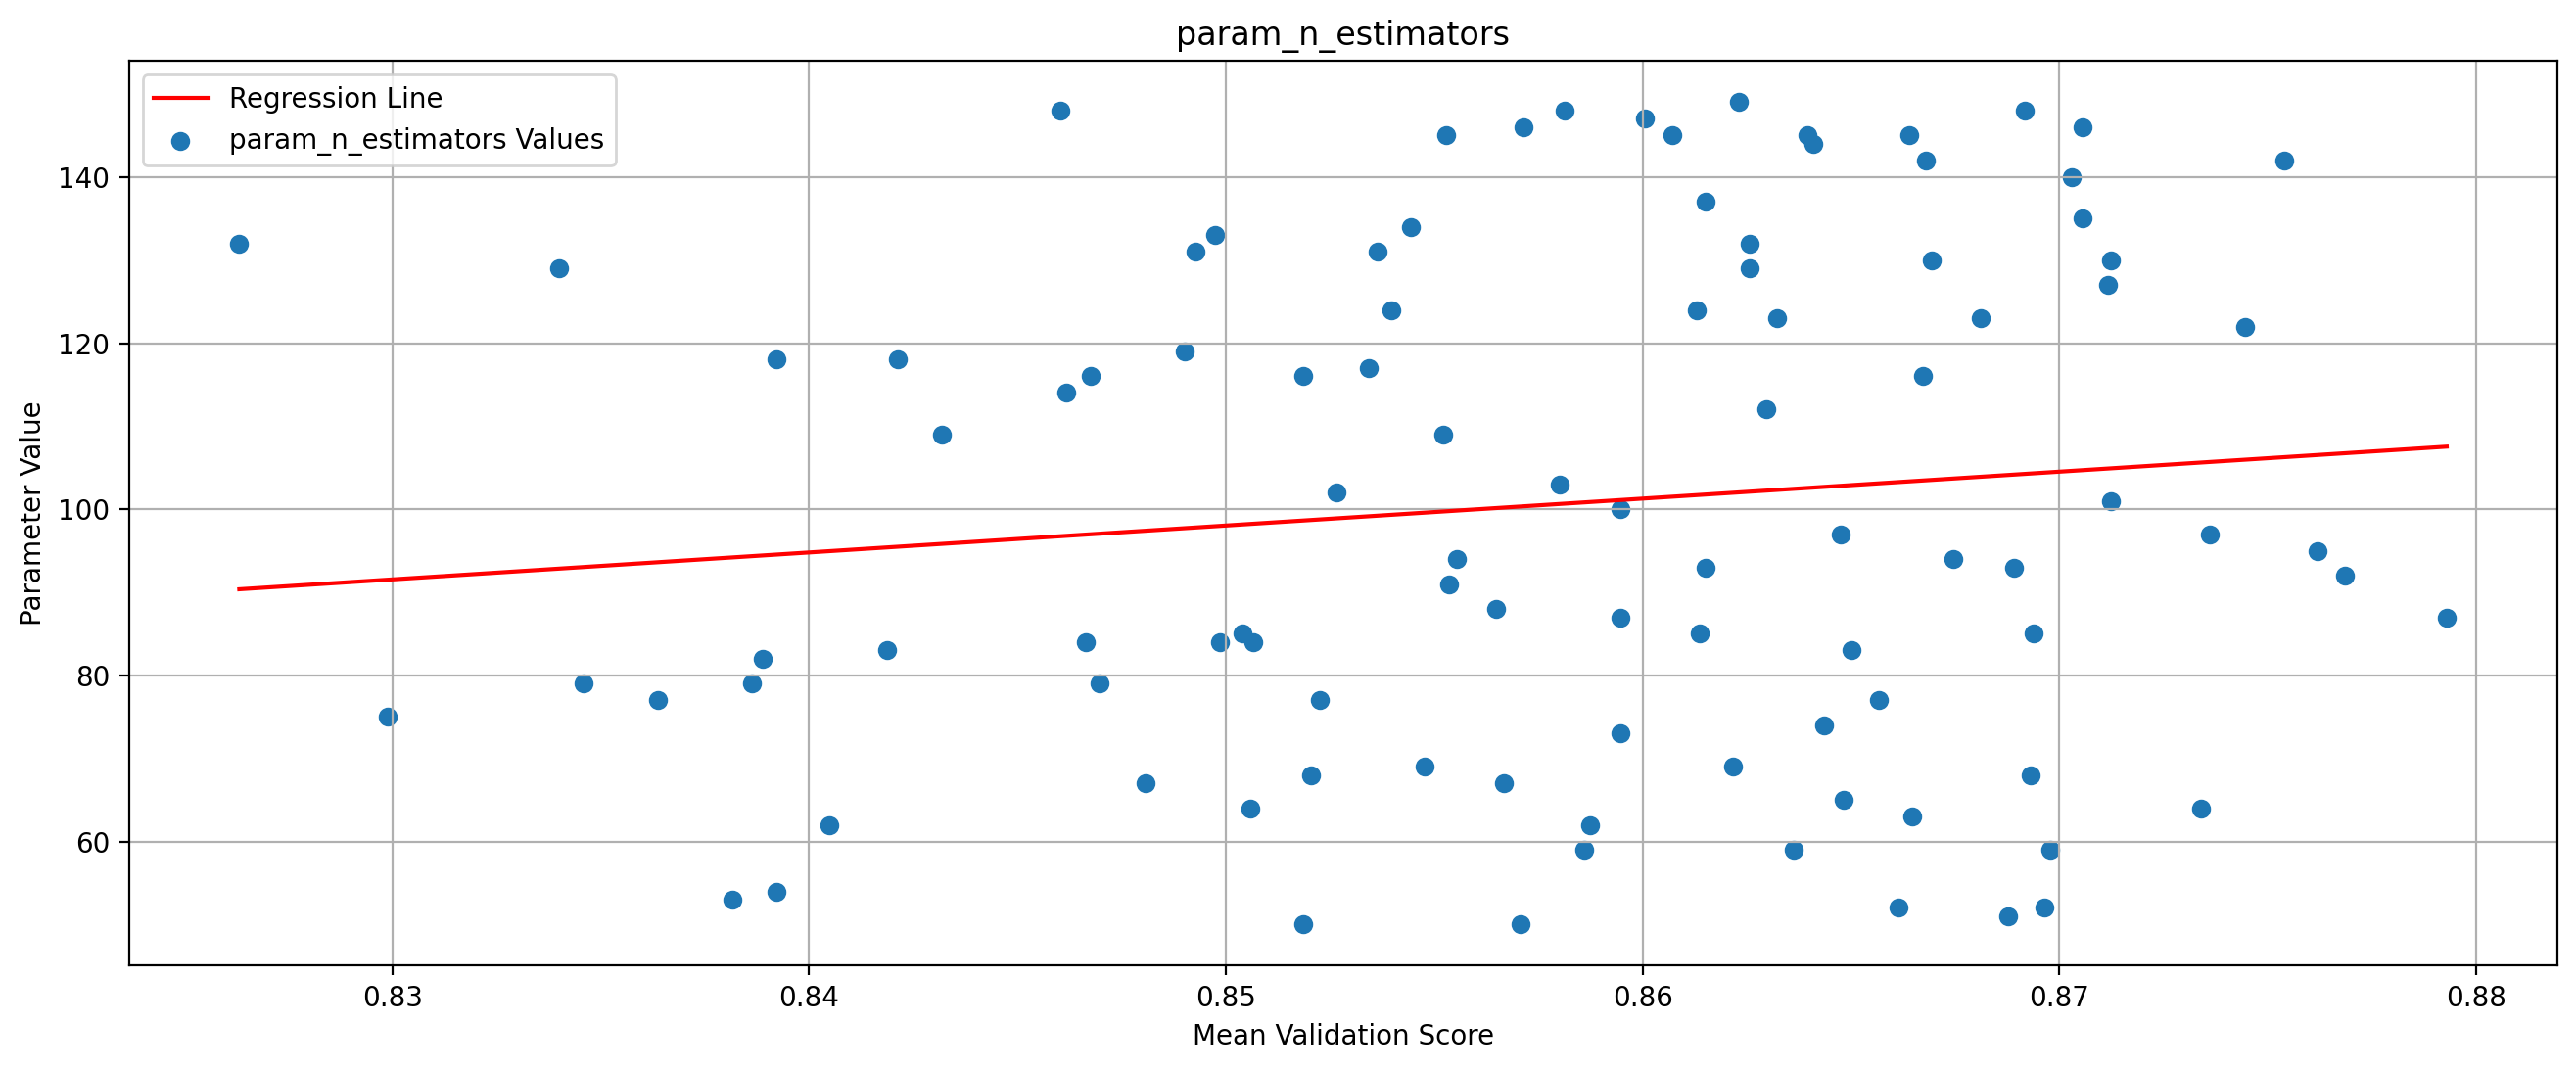

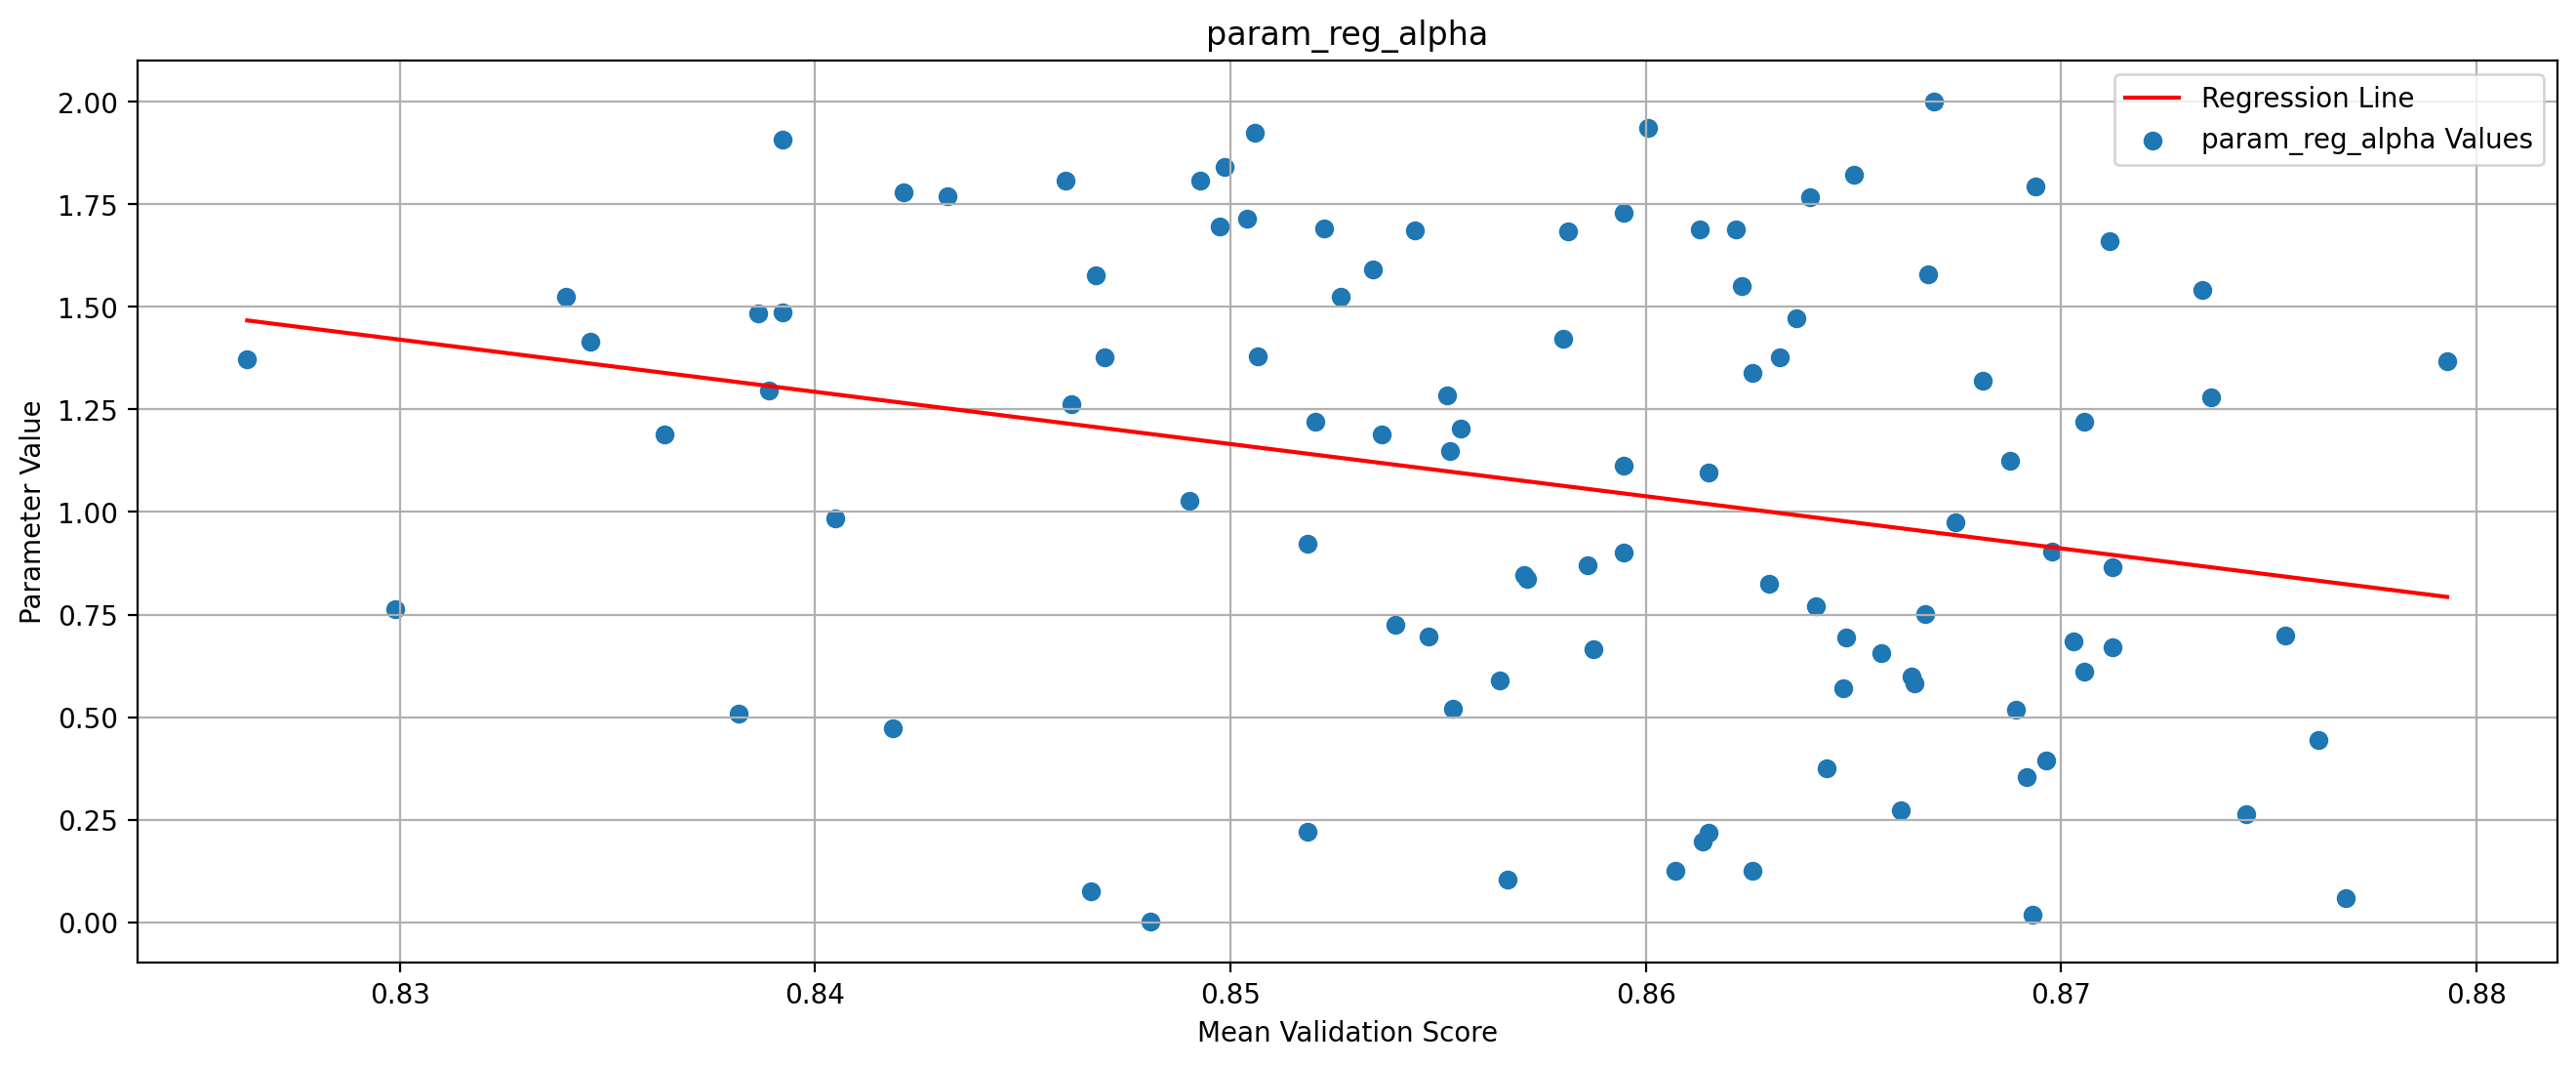

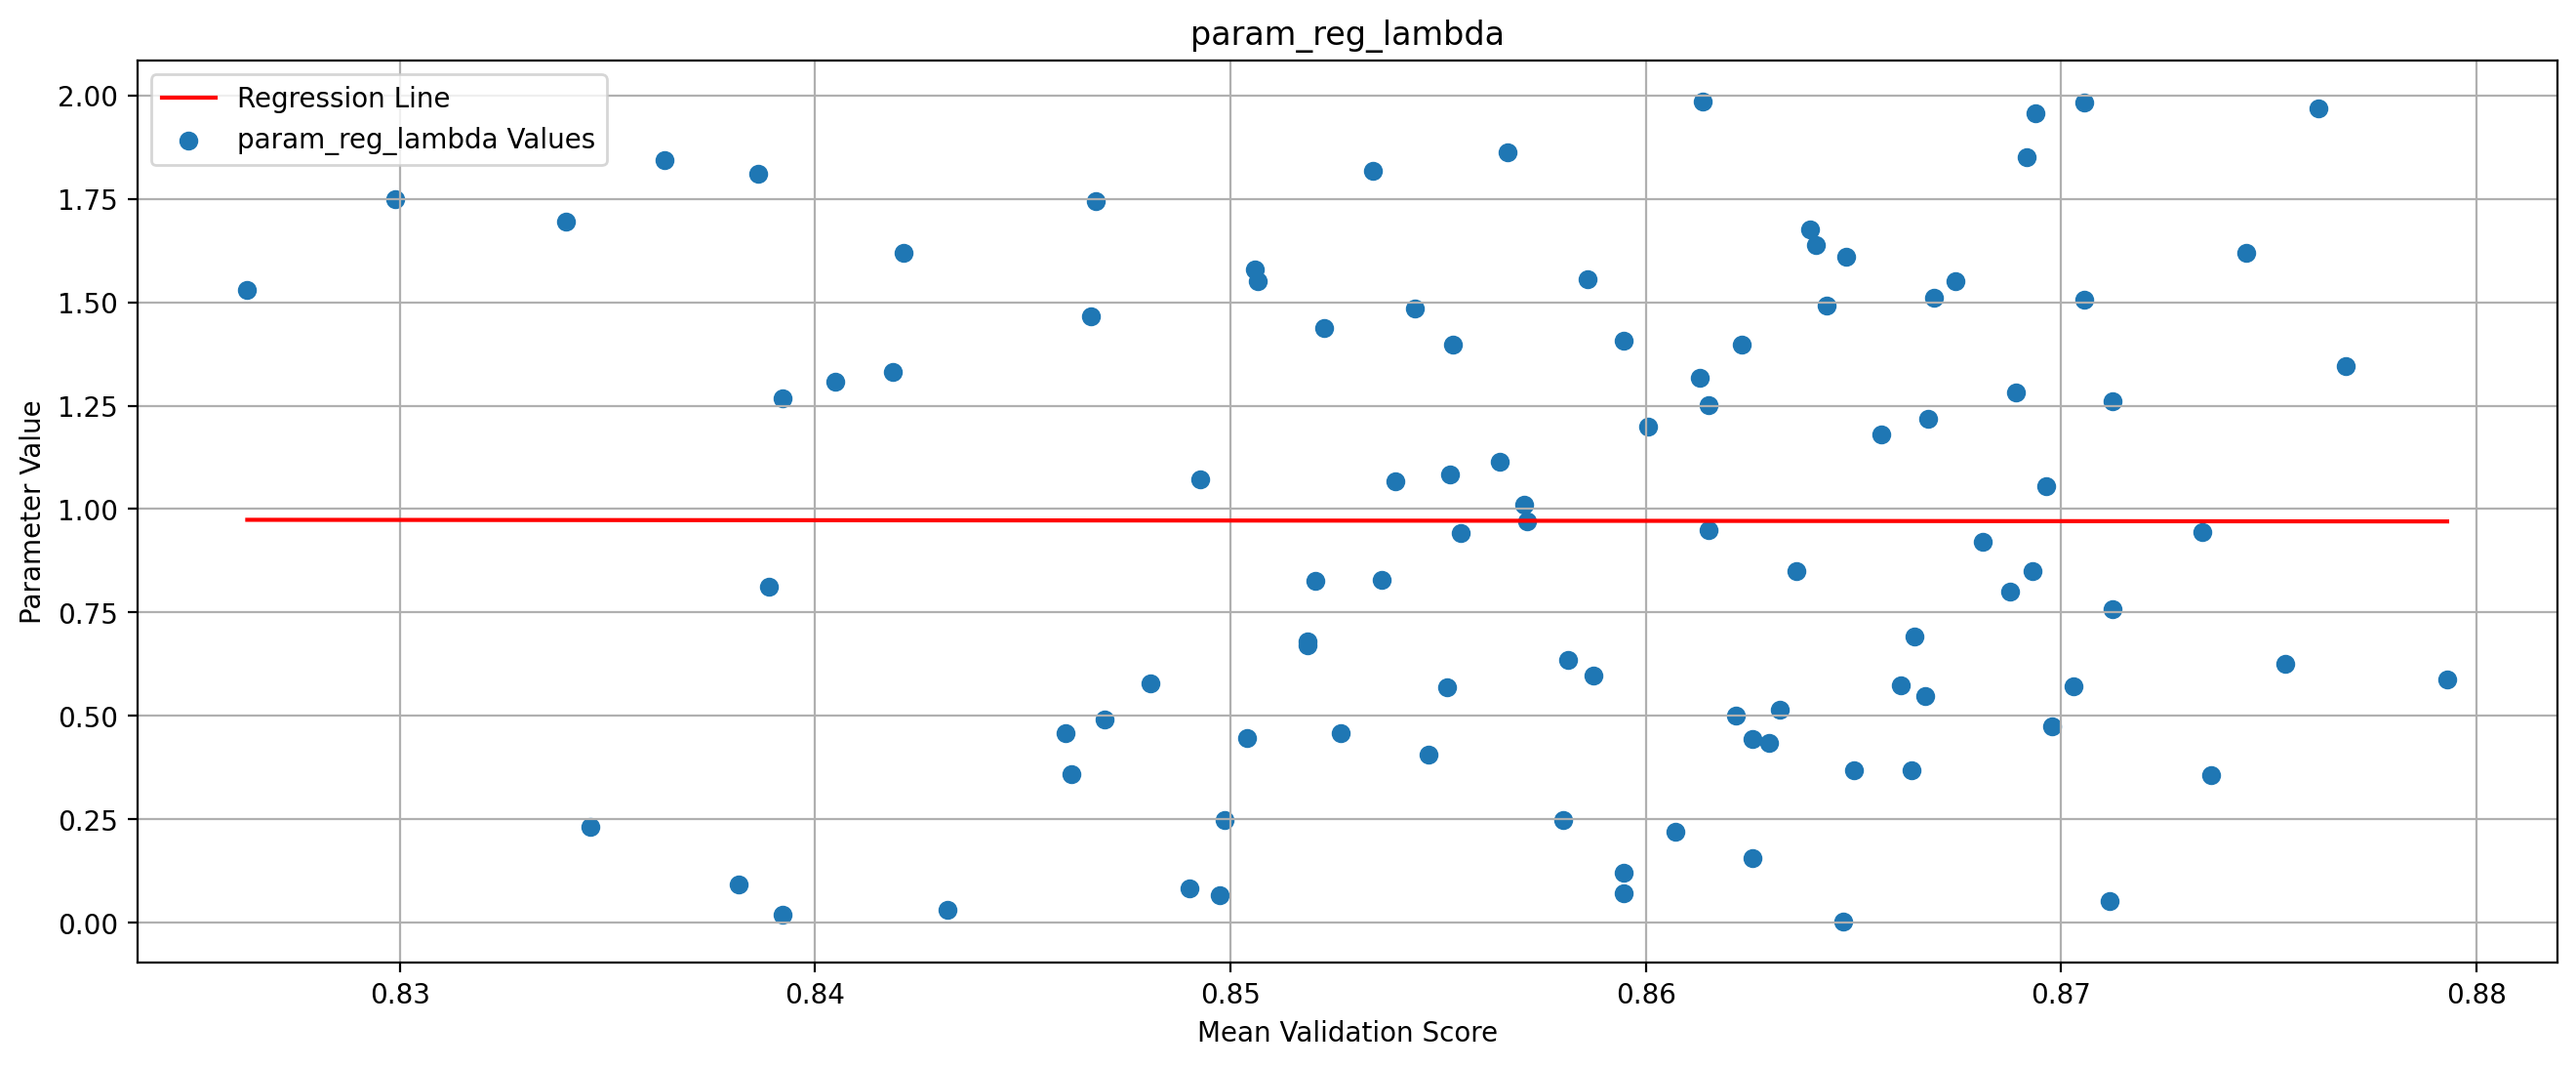

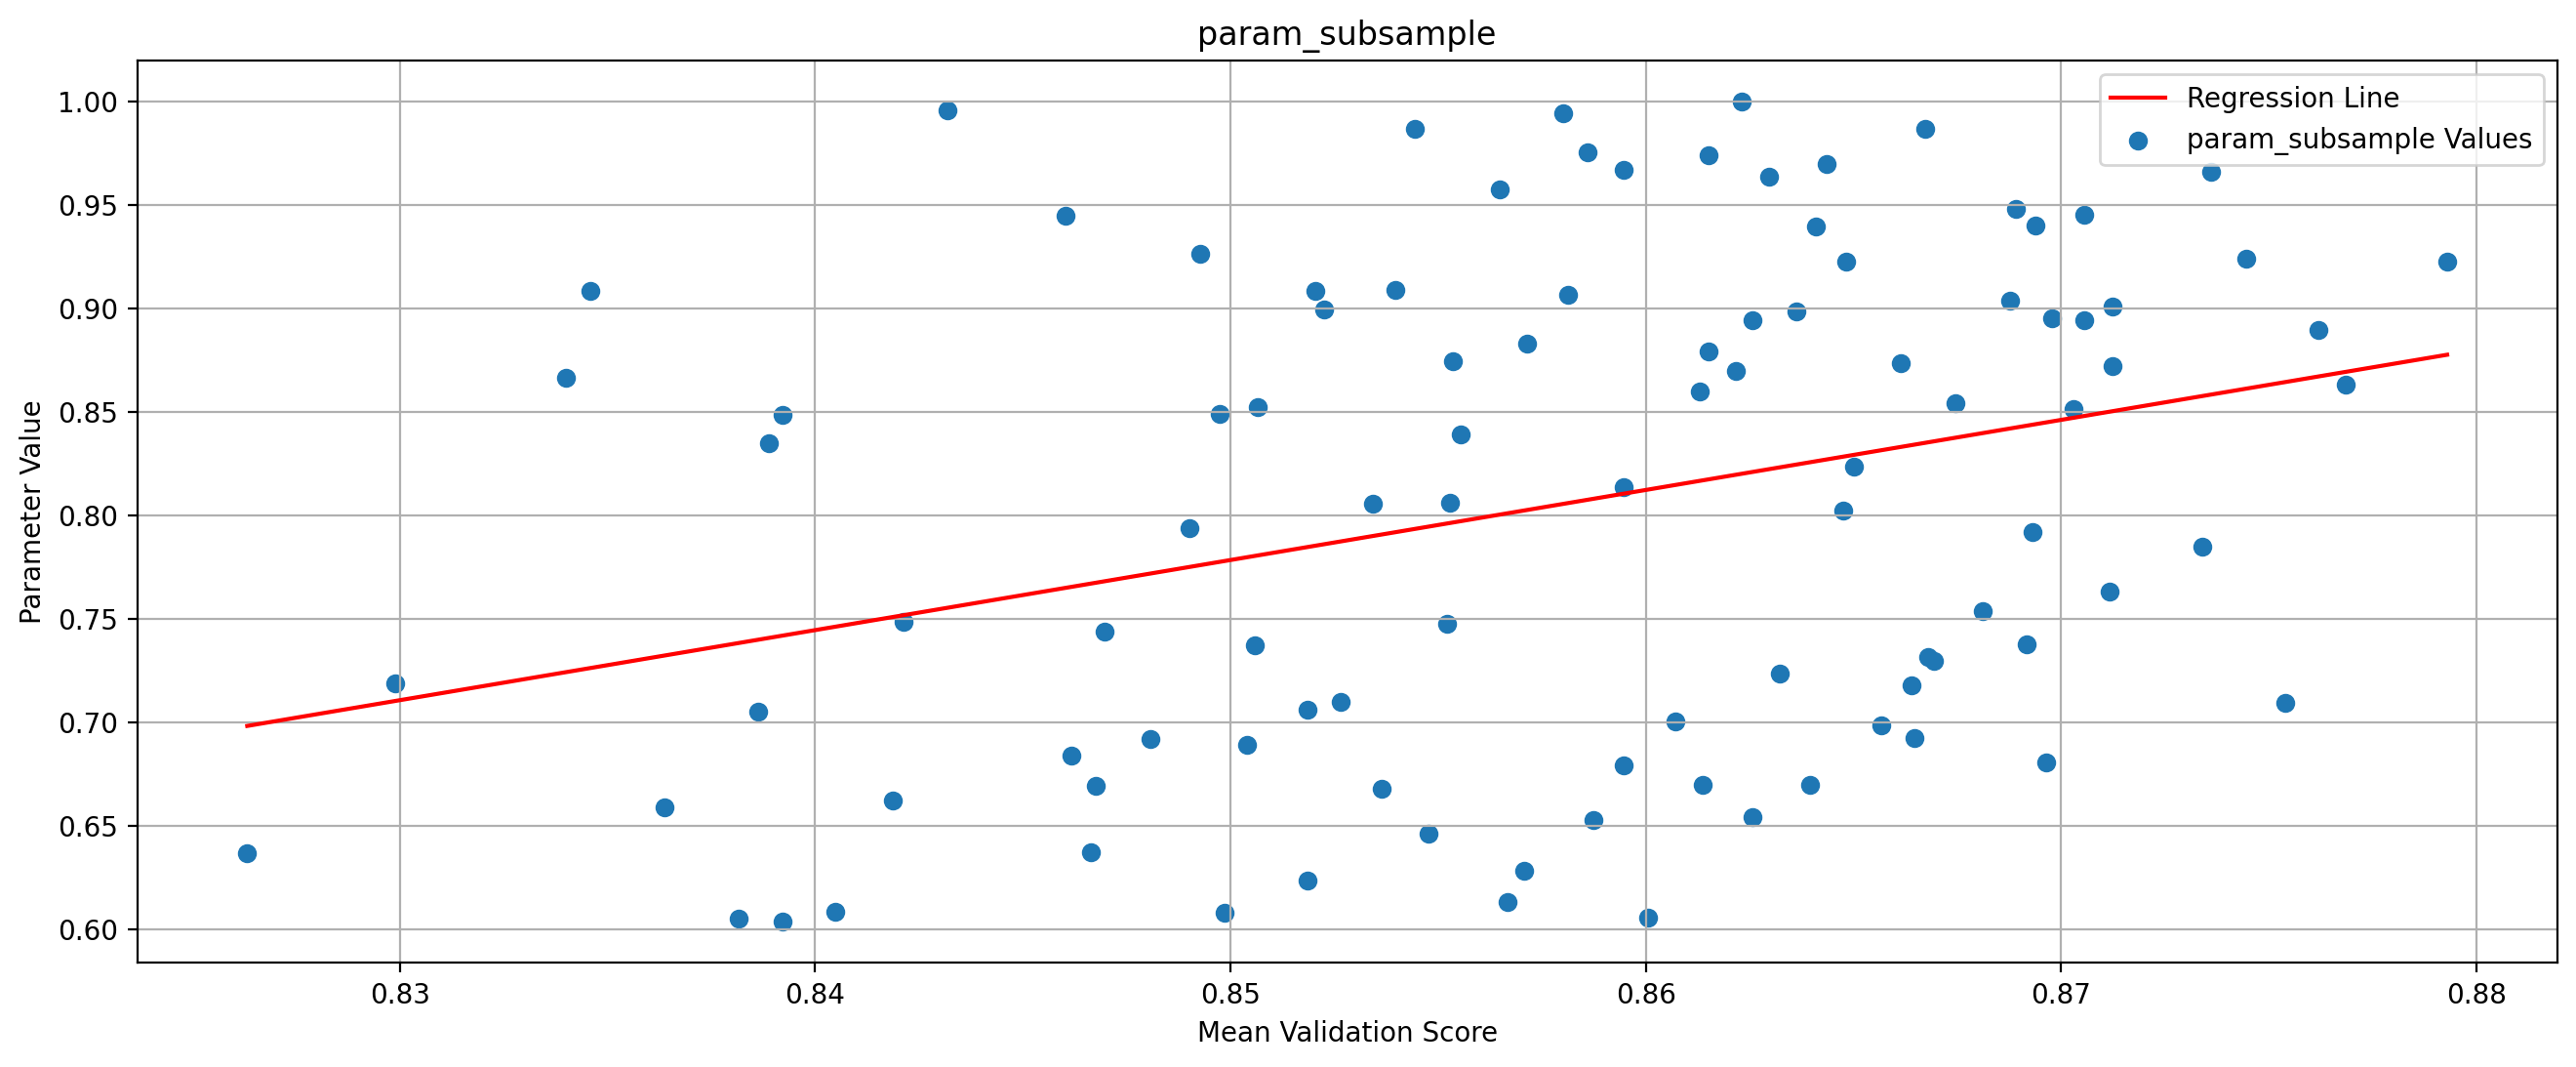

In [25]:
# TEST
for col in ['param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['mean_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['mean_test_score'], m * sorted_cv['mean_test_score'] + b, c='r', label="Regression Line")
    plt.scatter(sorted_cv['mean_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Mean Validation Score')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [26]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    #ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r', label='std_test_score')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



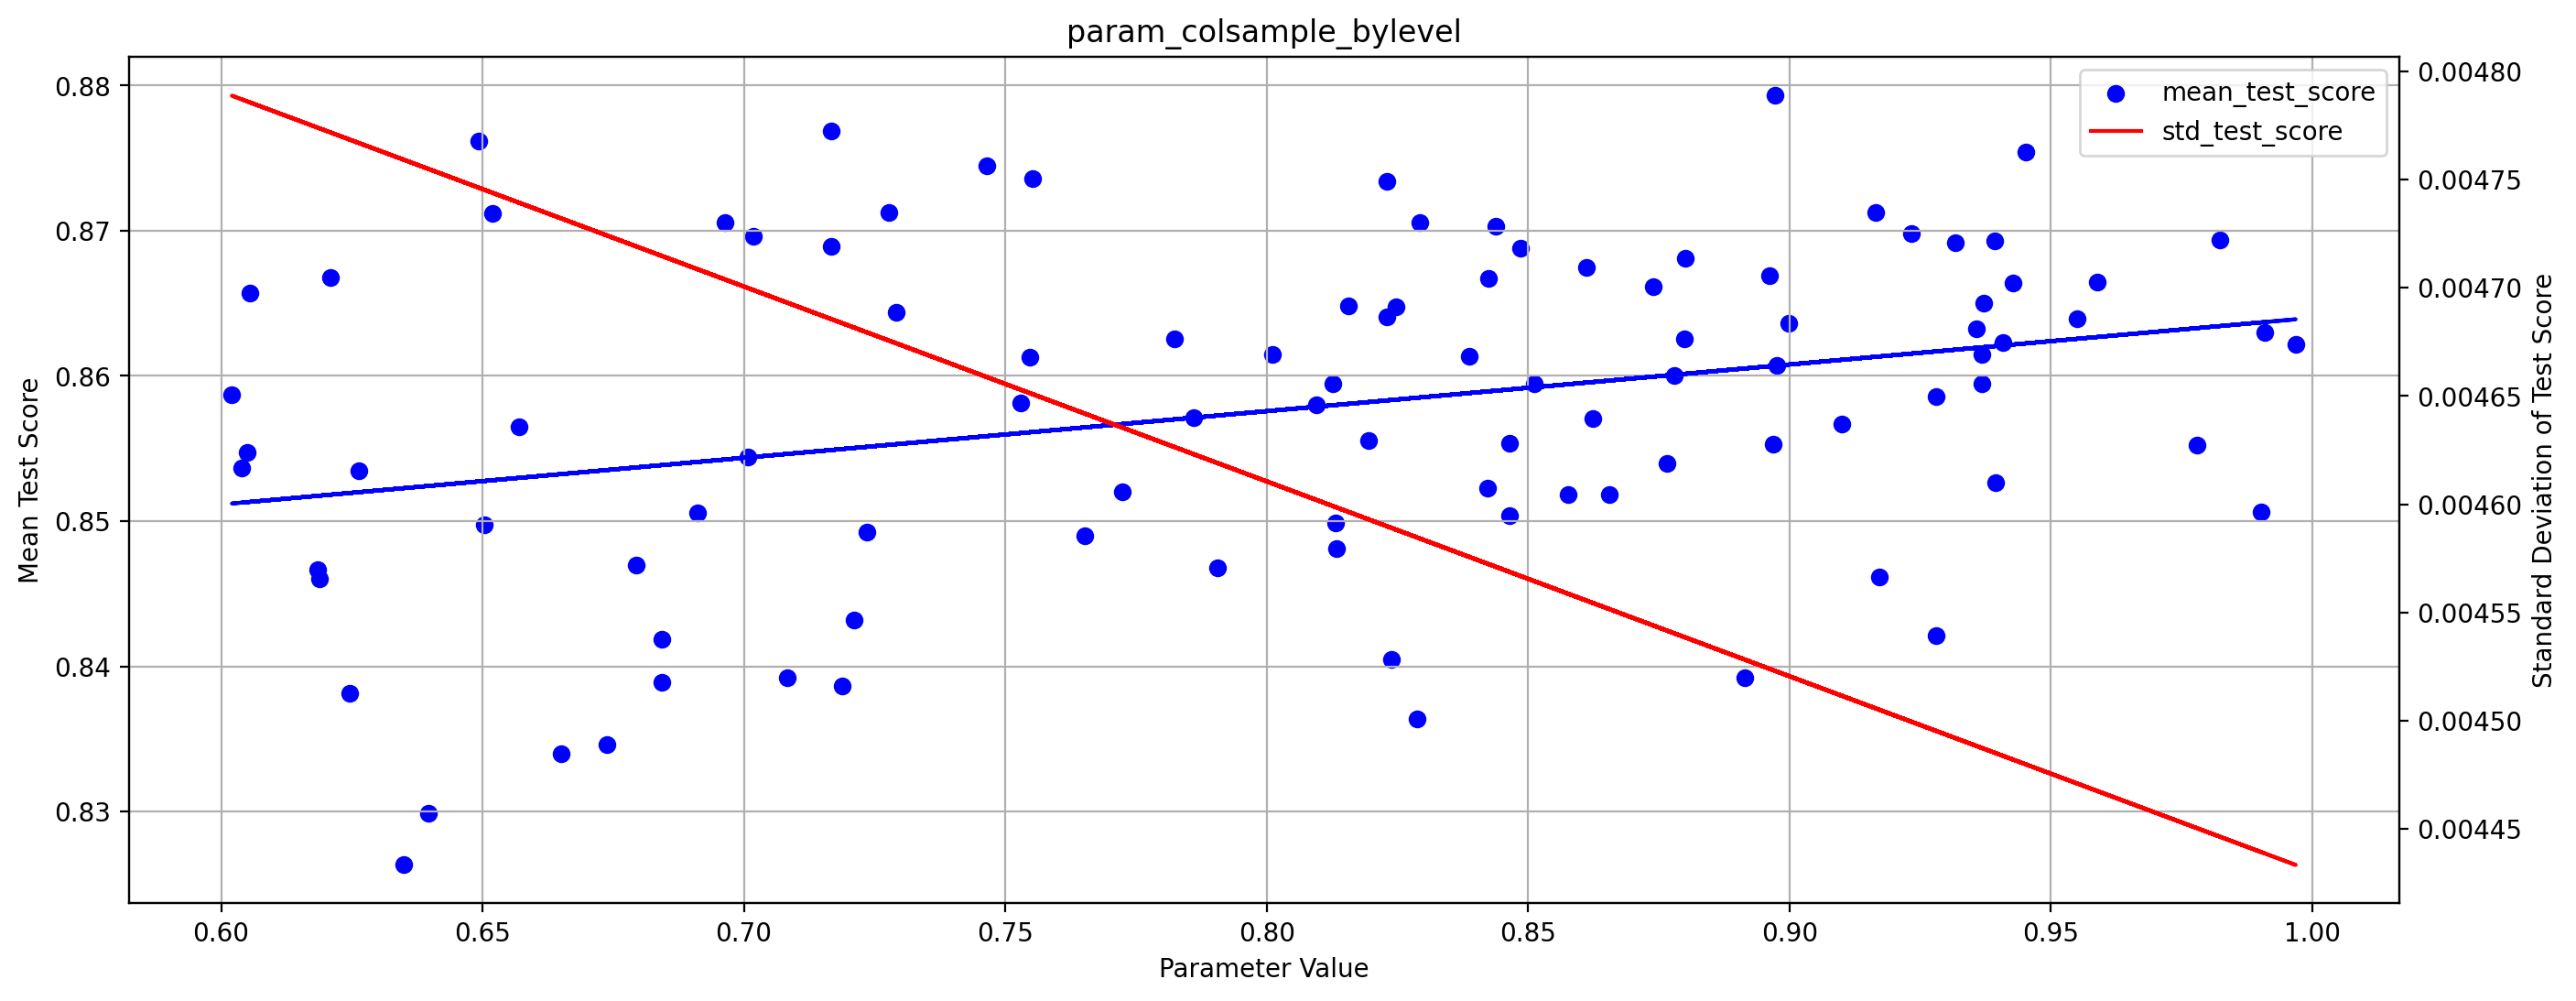

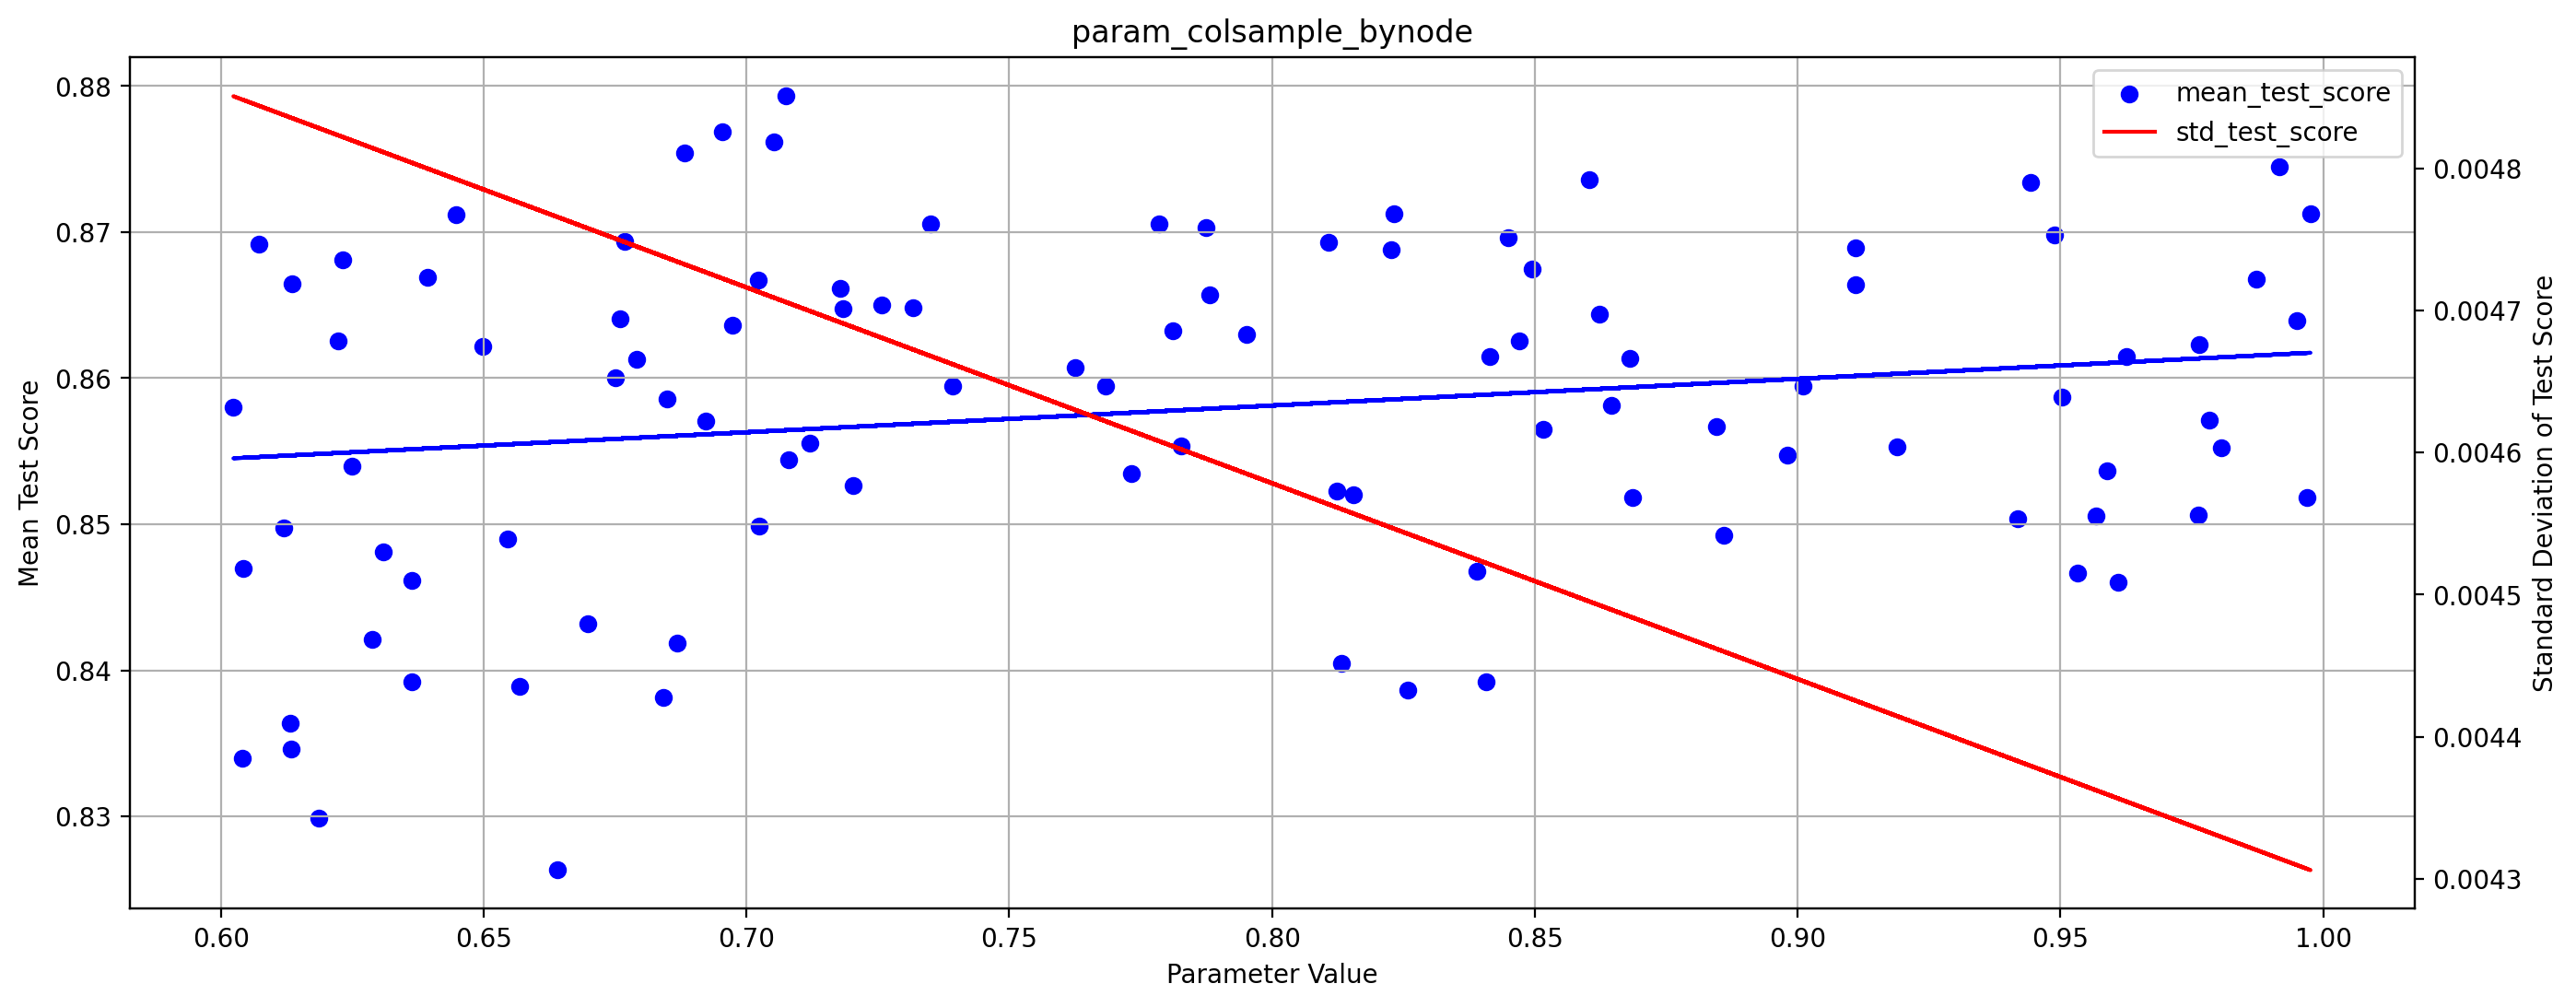

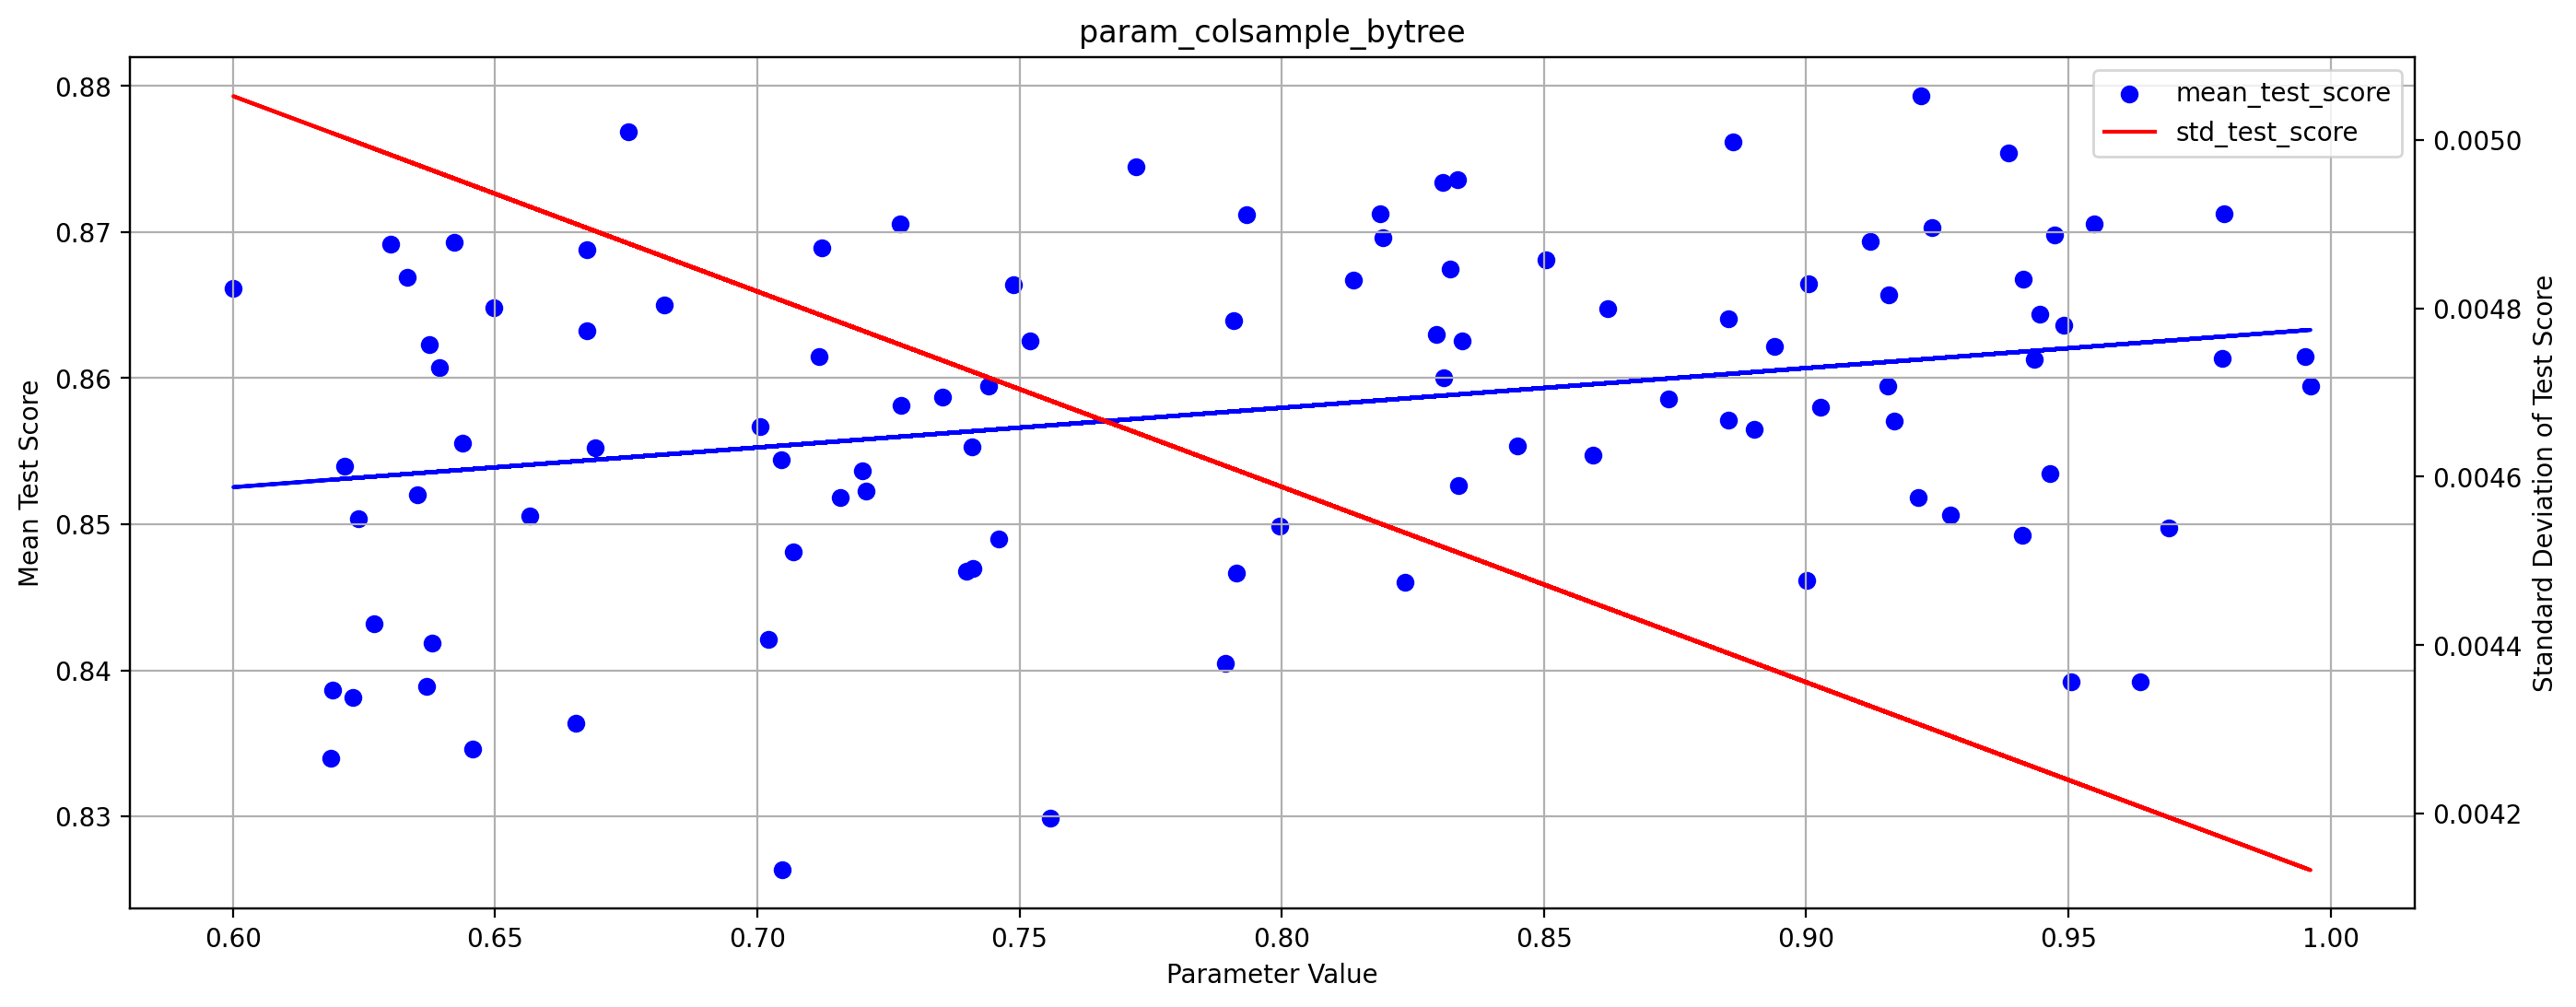

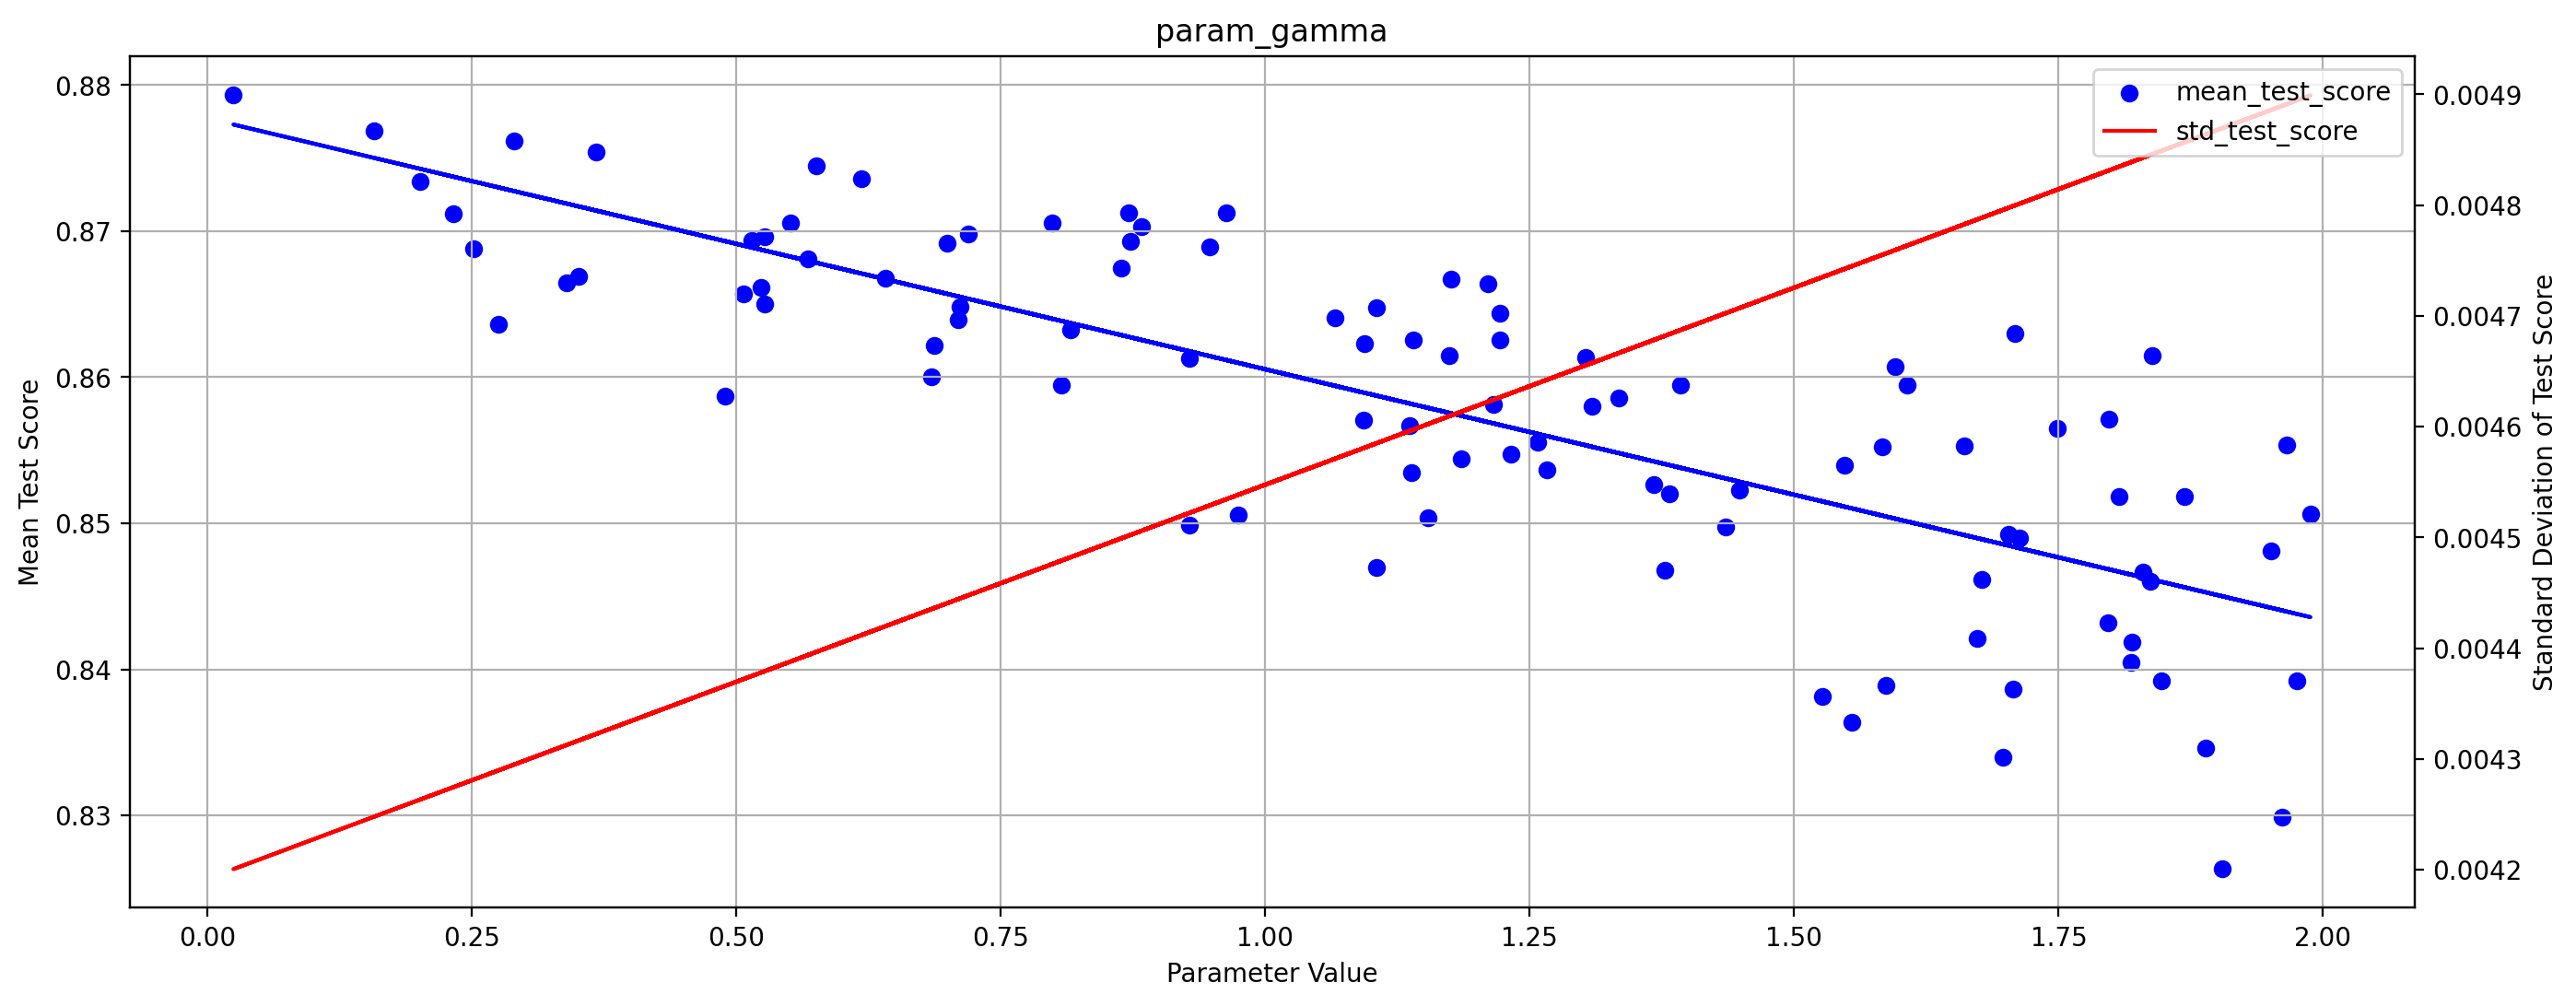

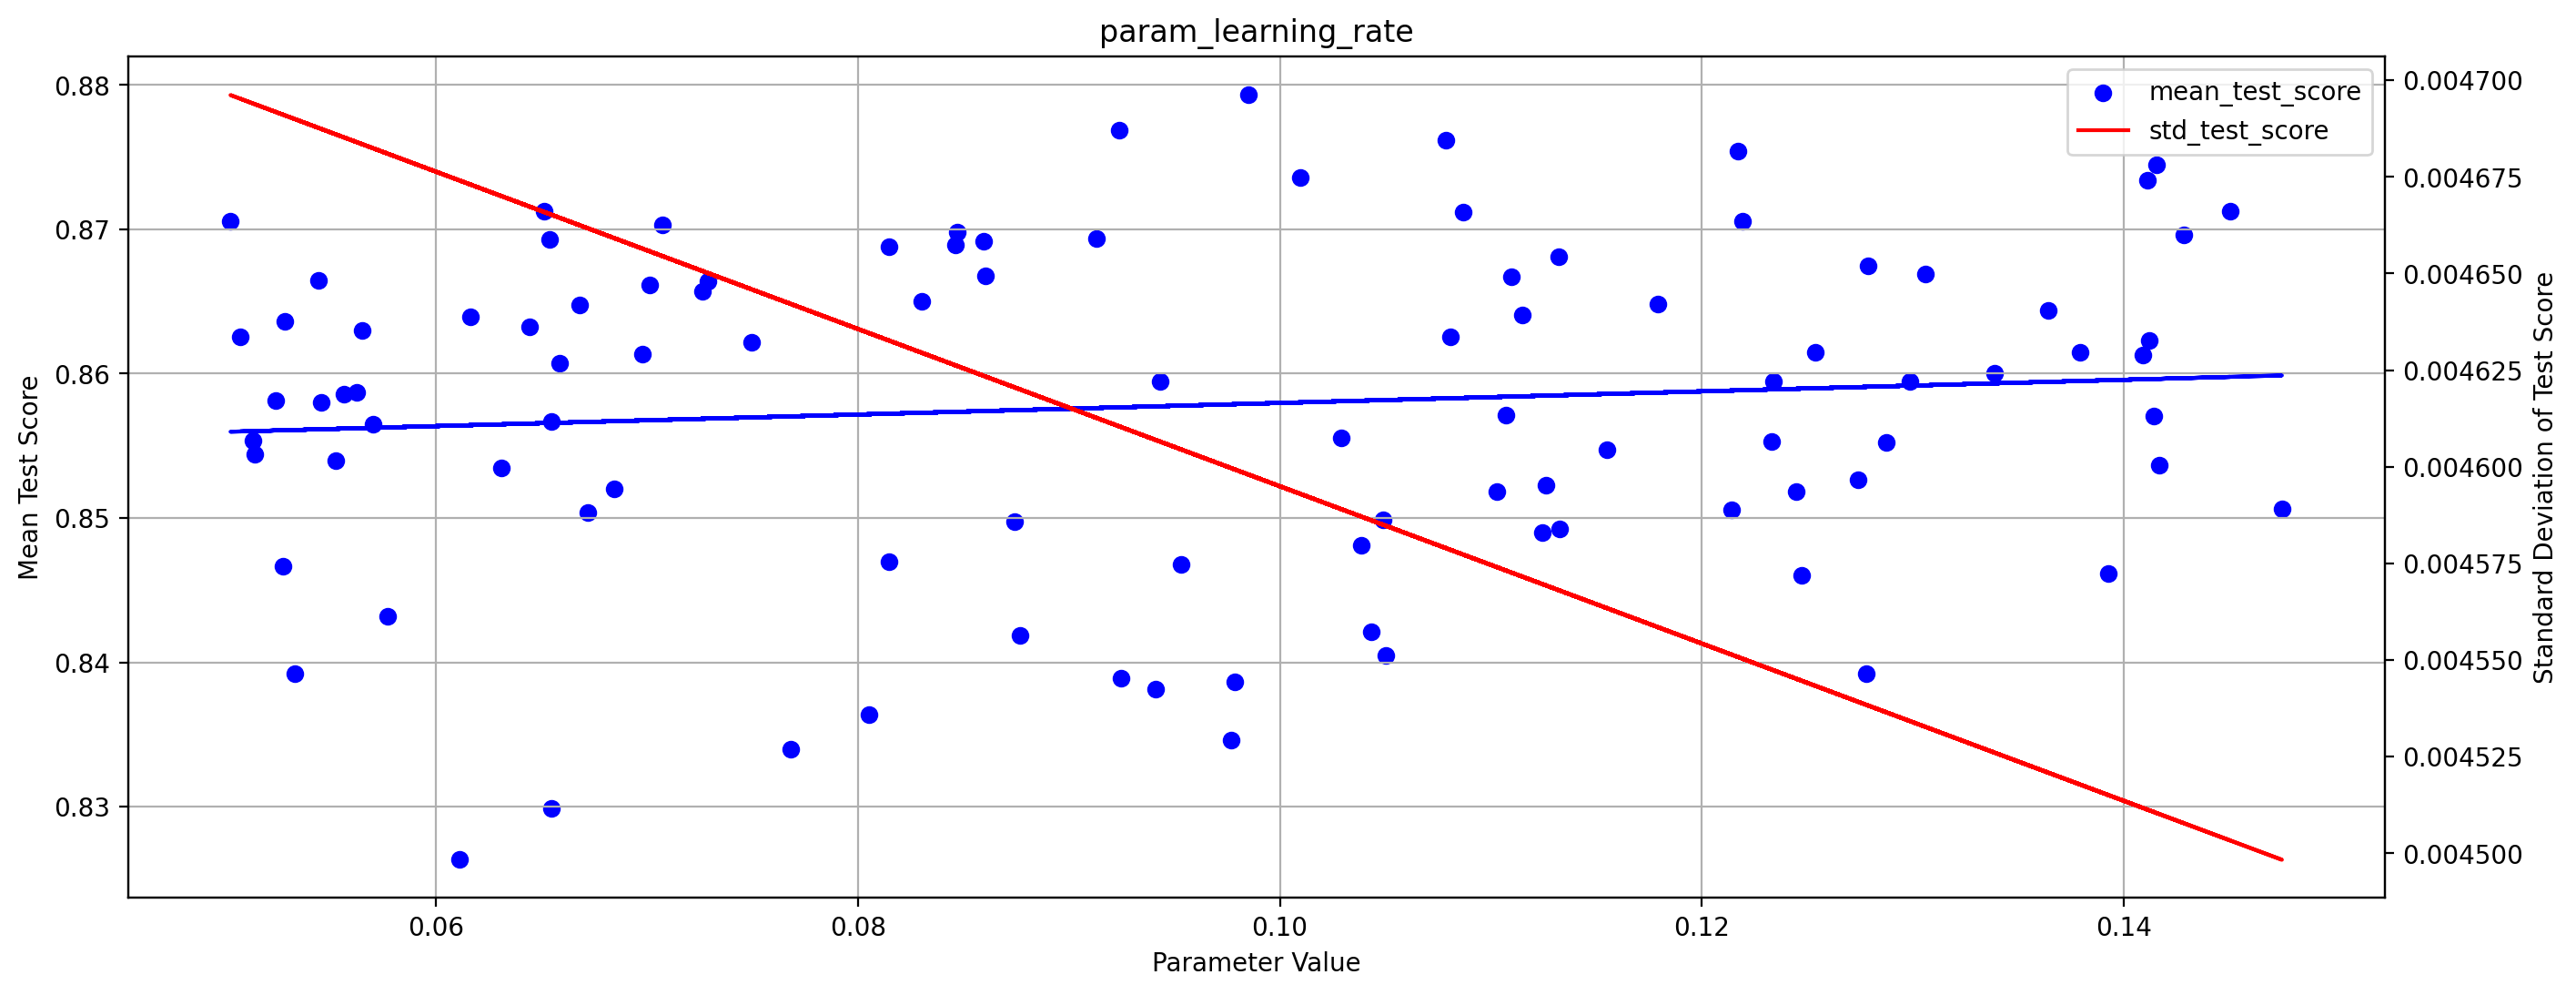

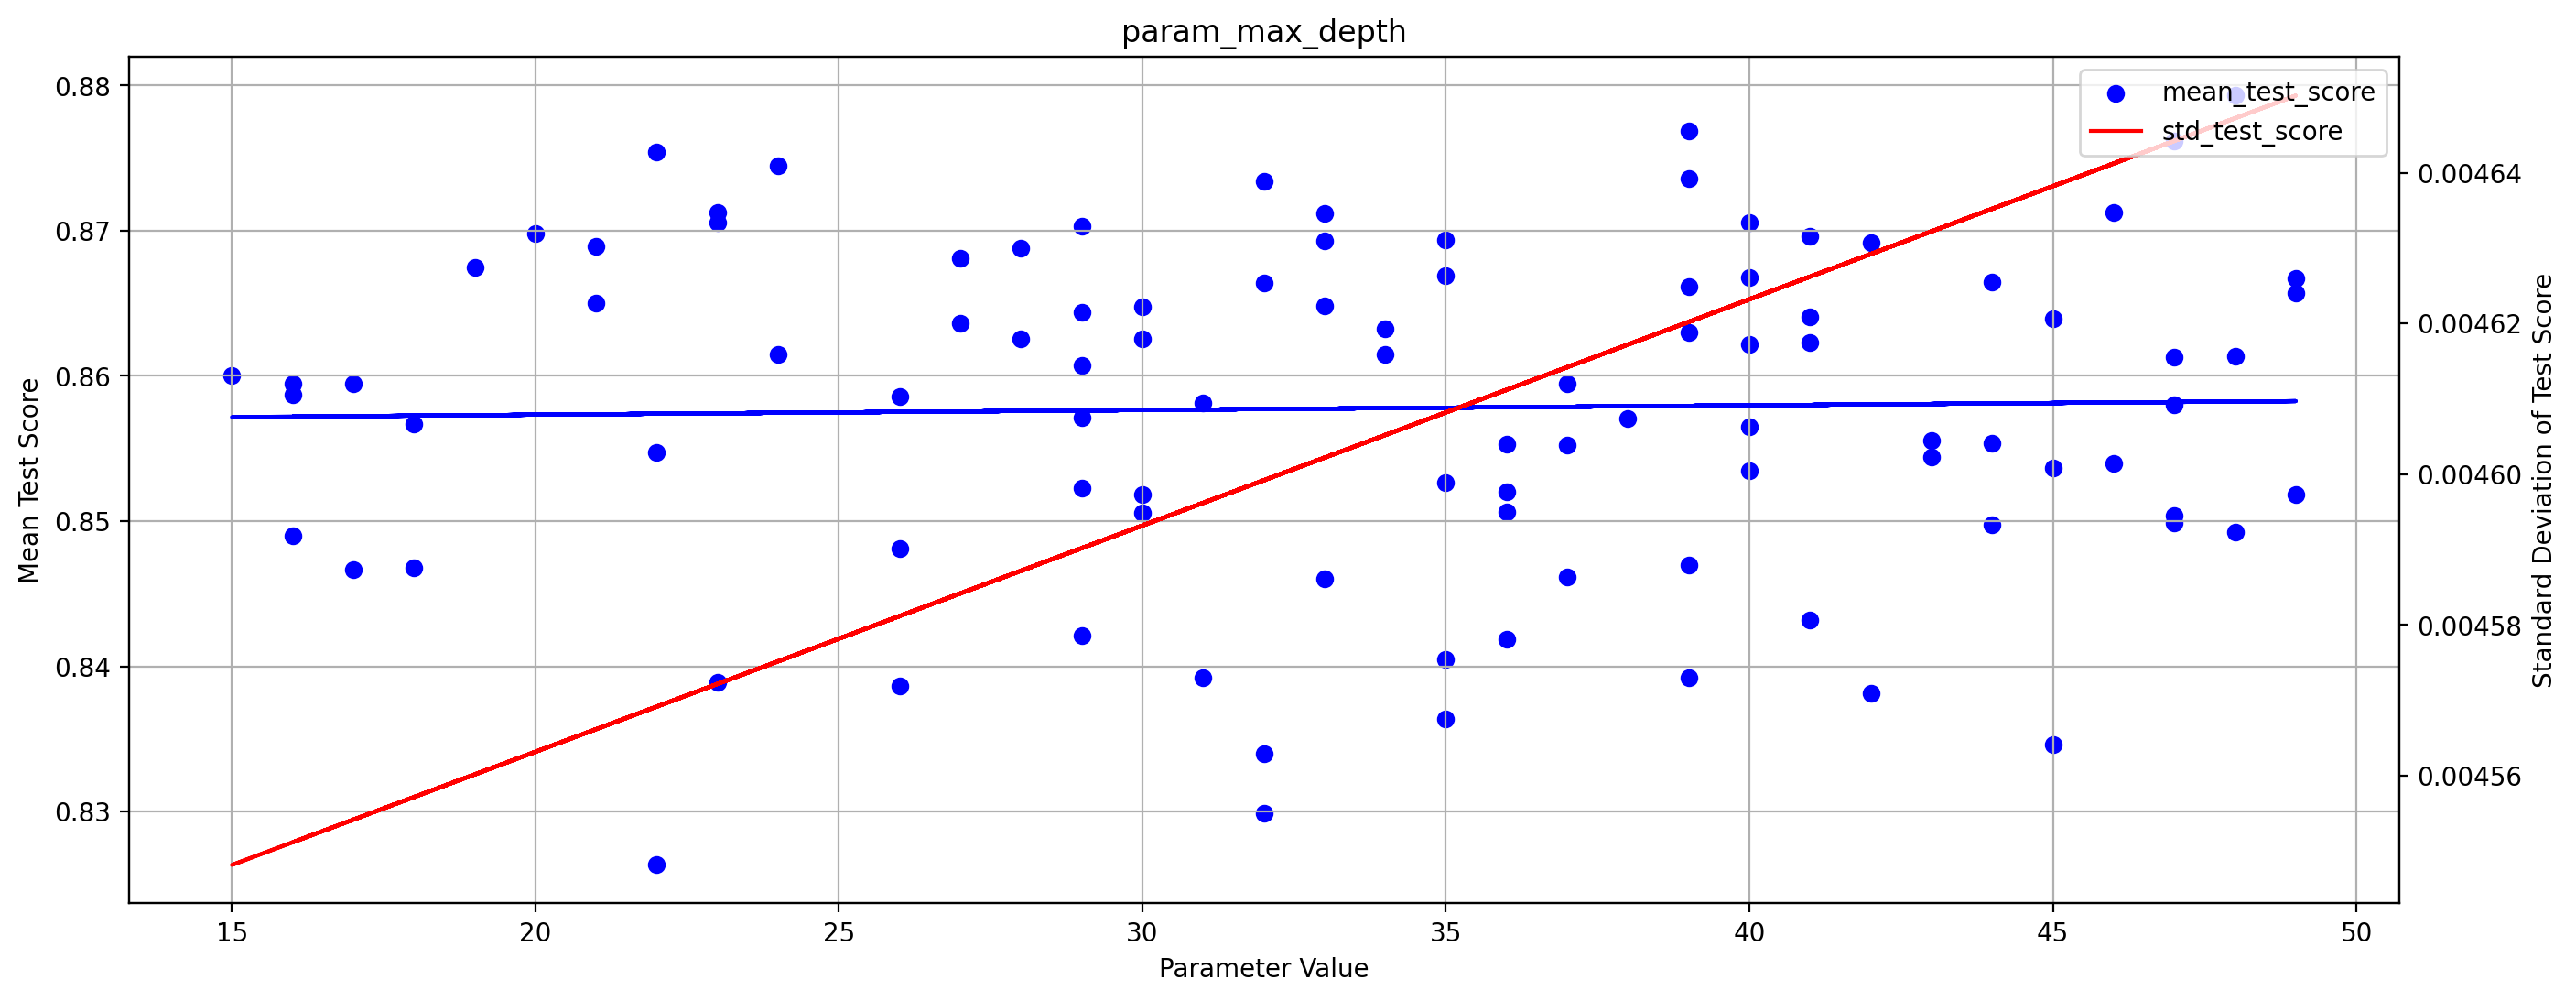

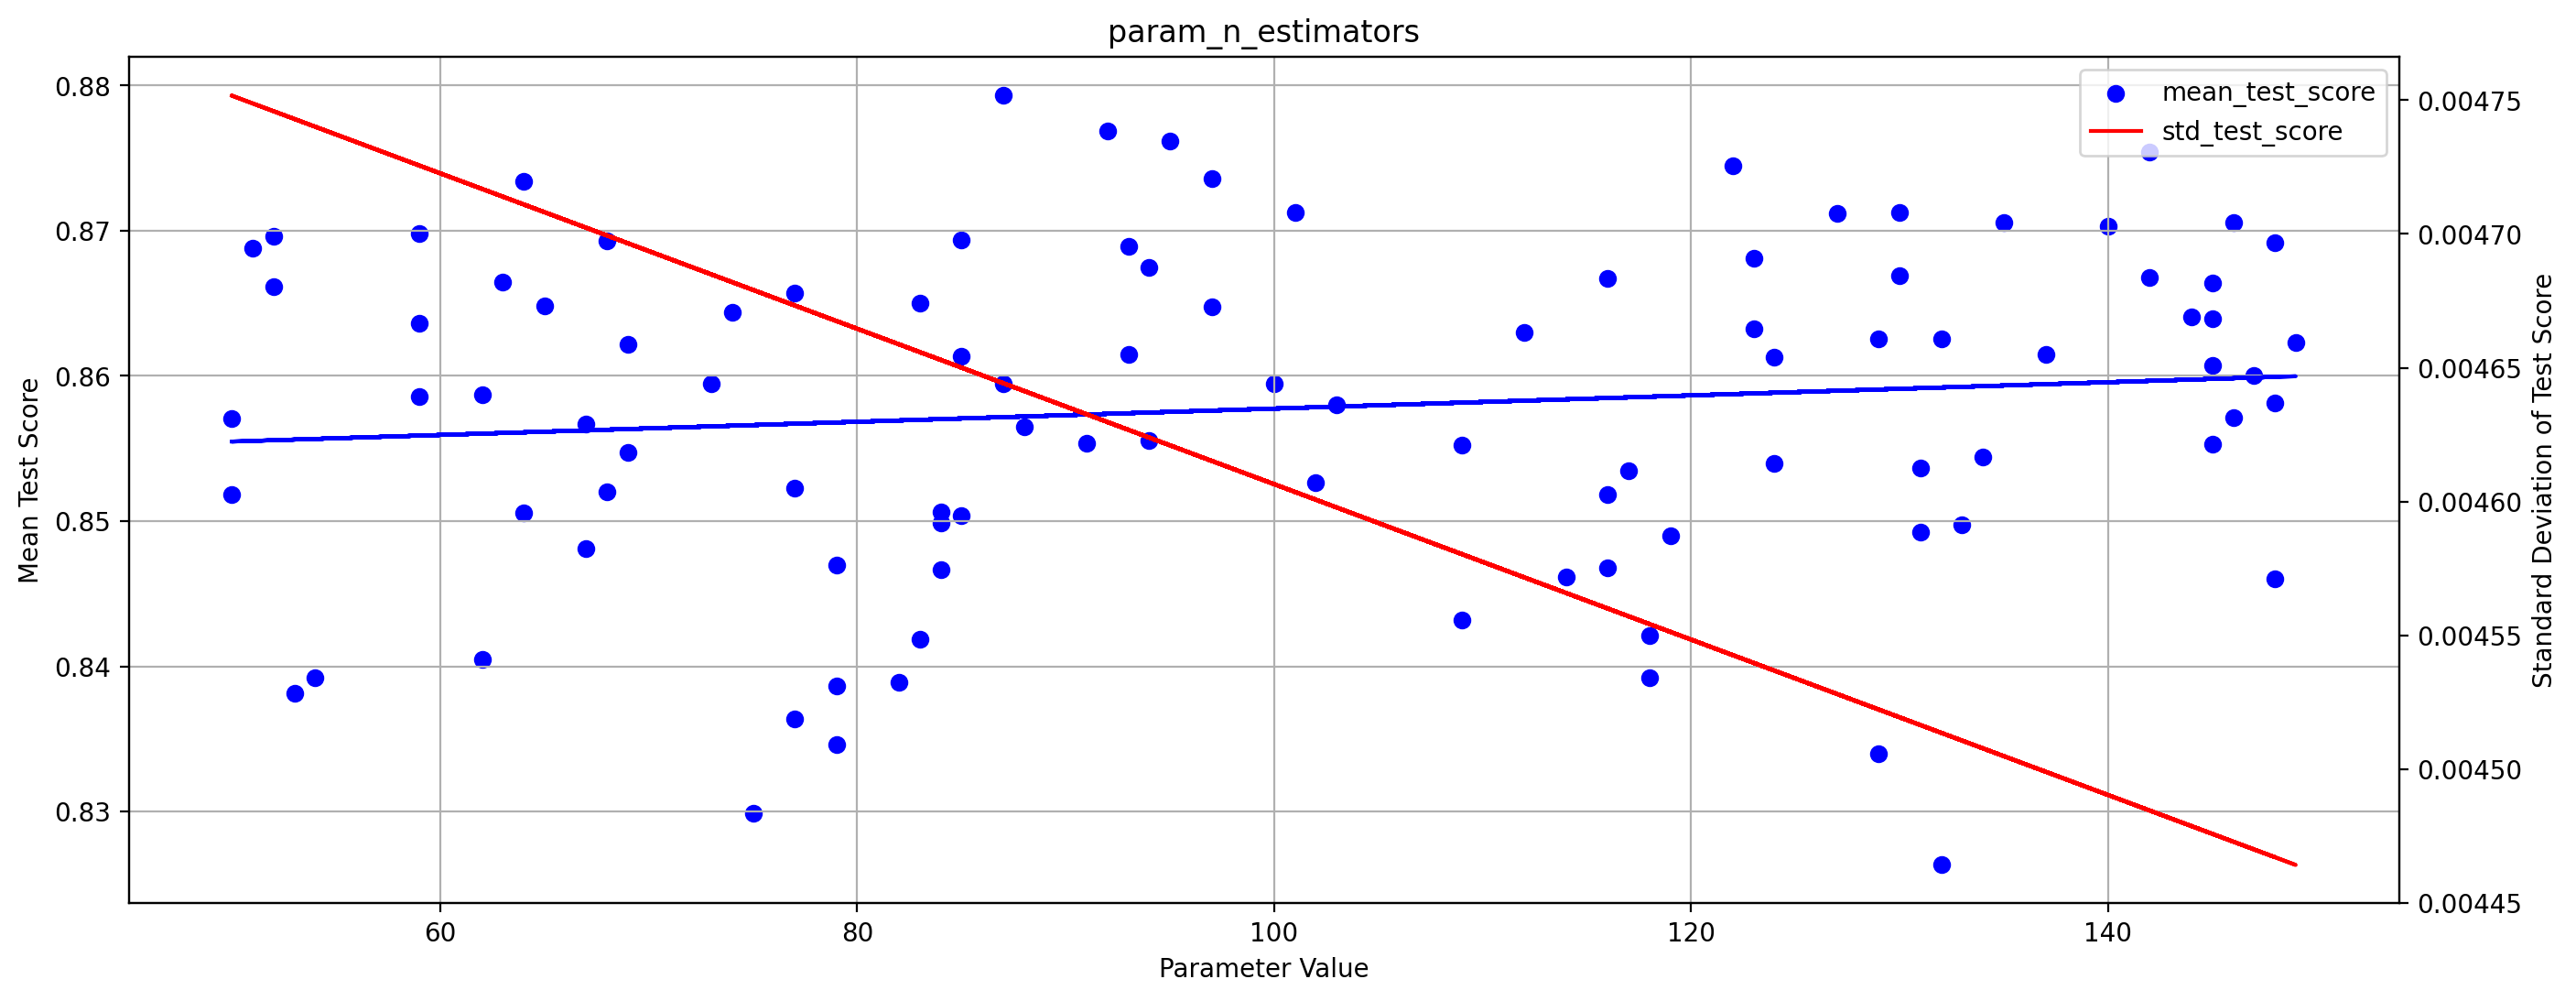

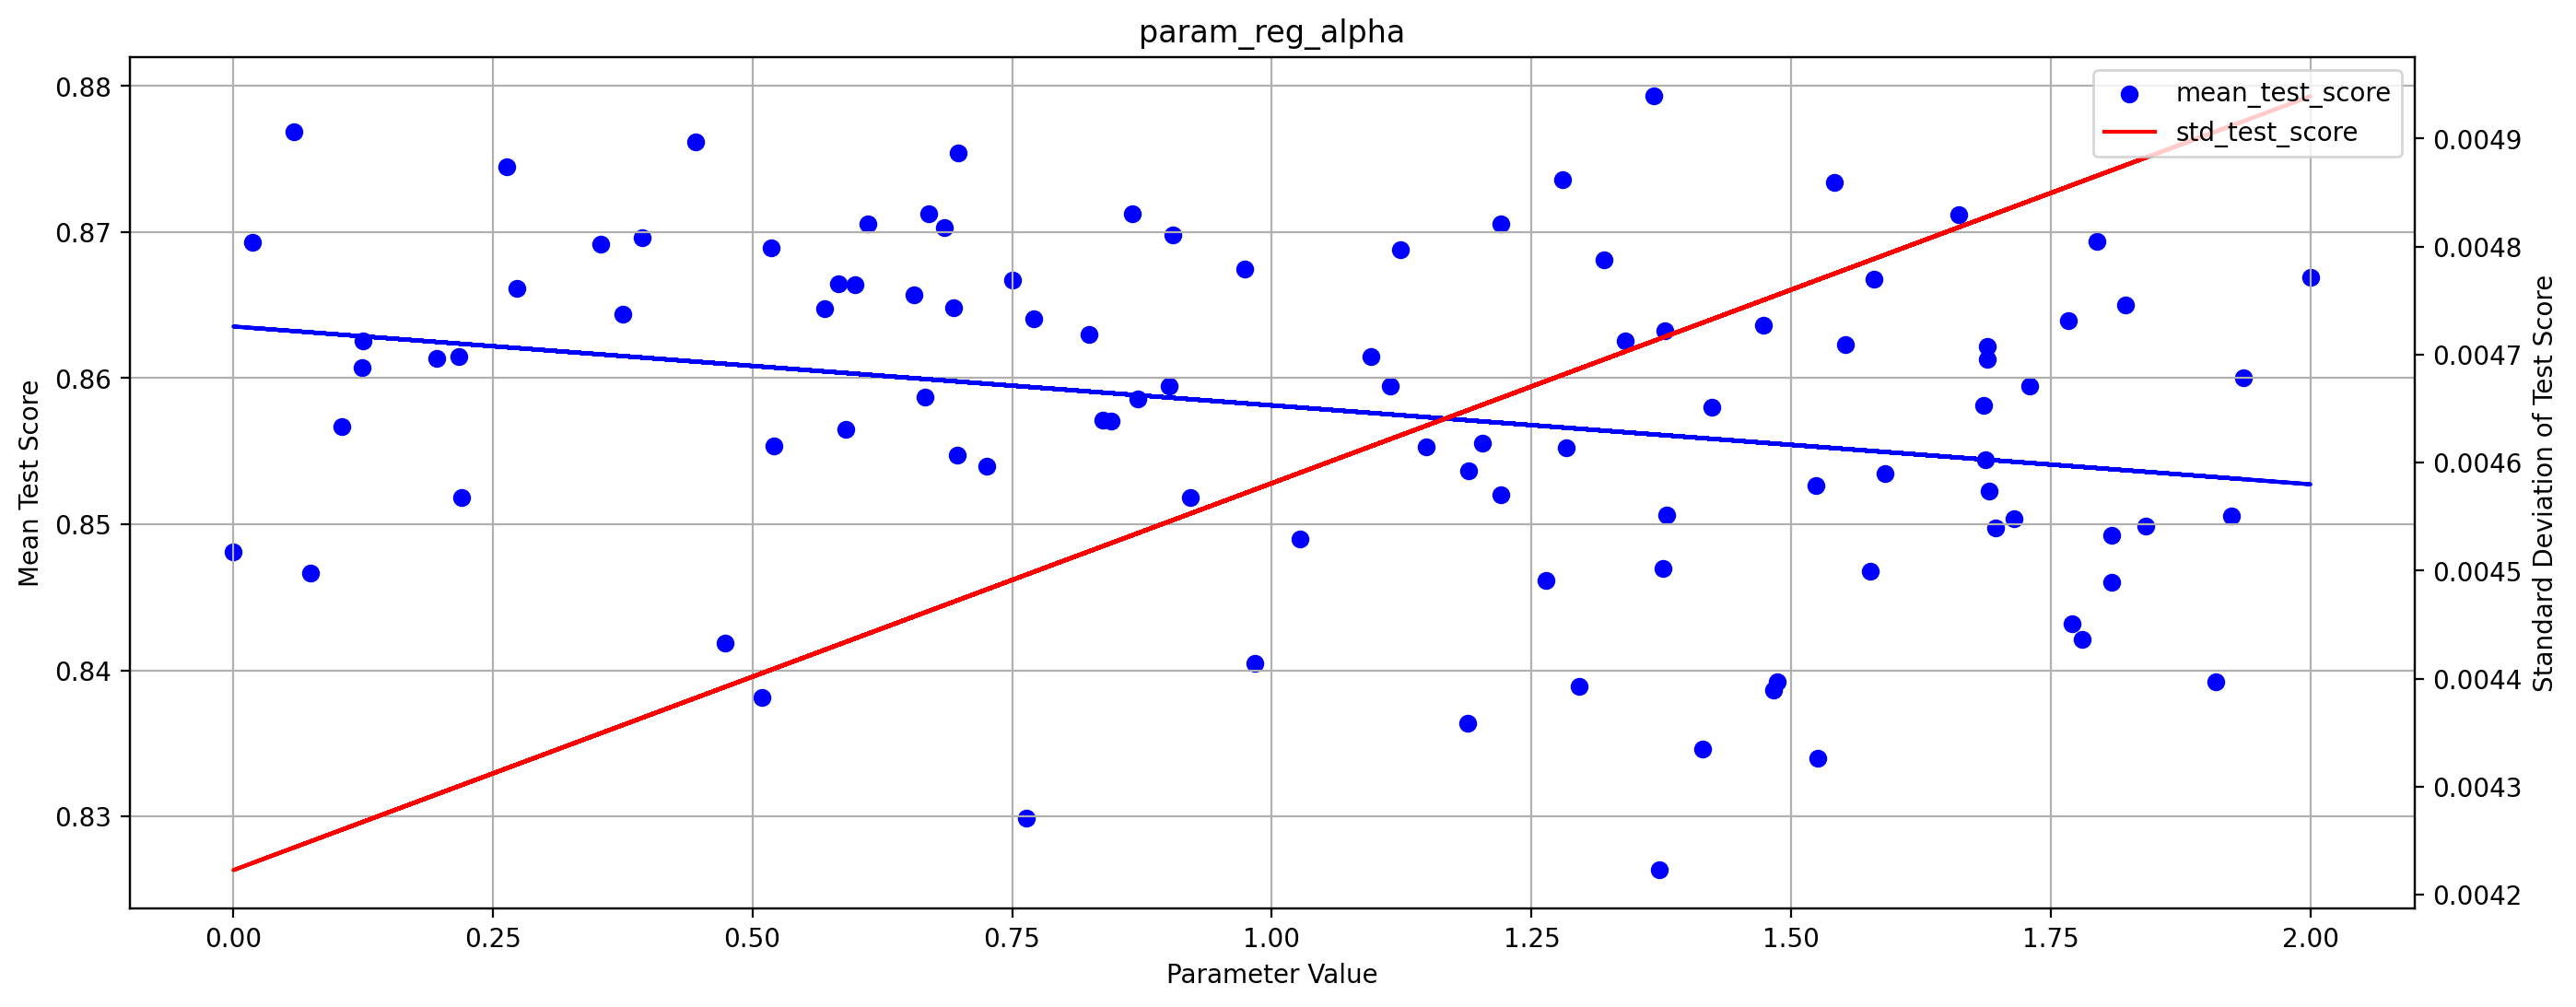

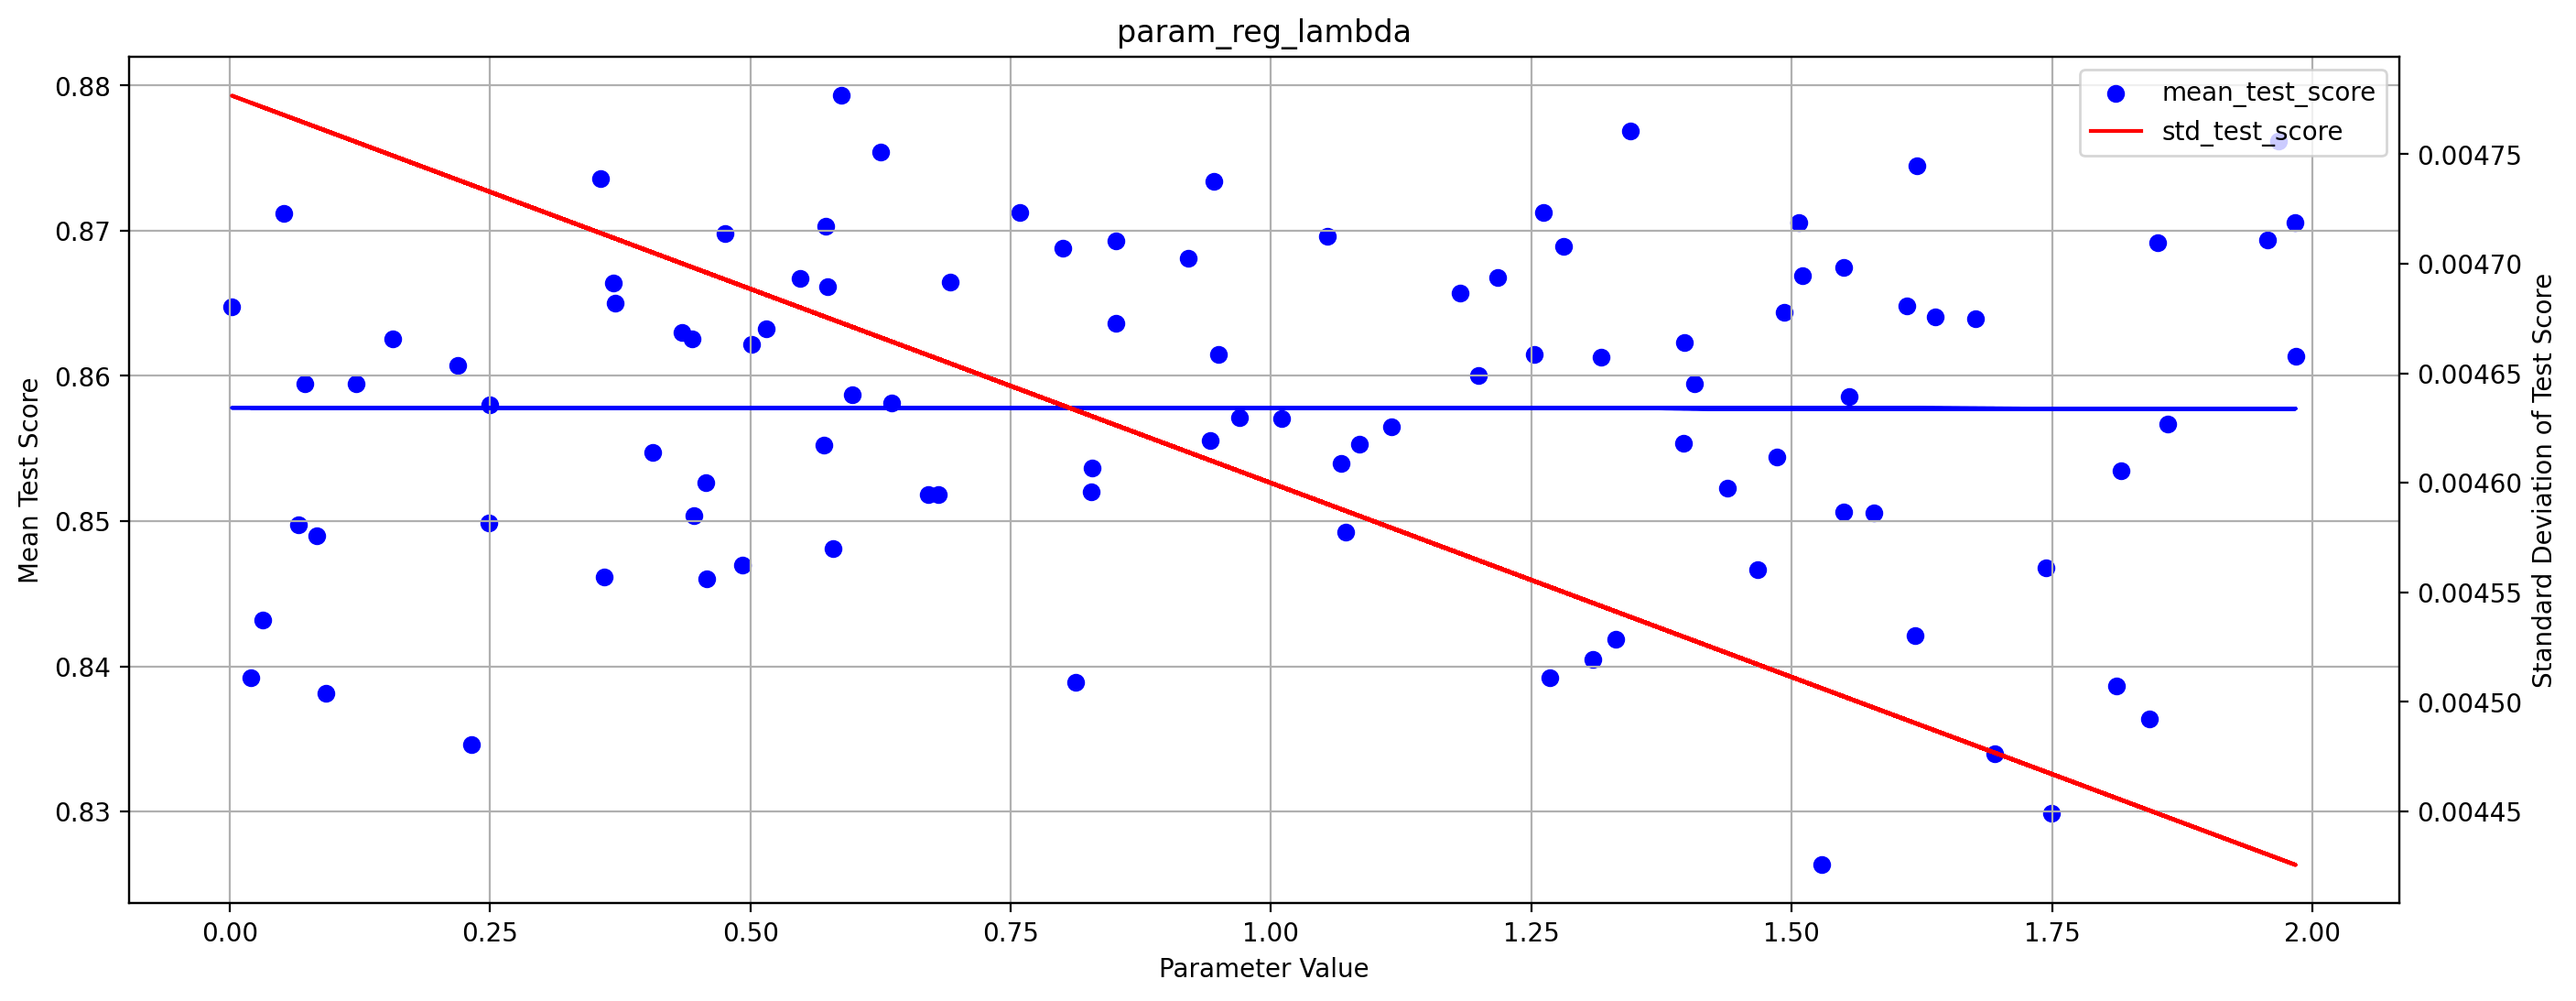

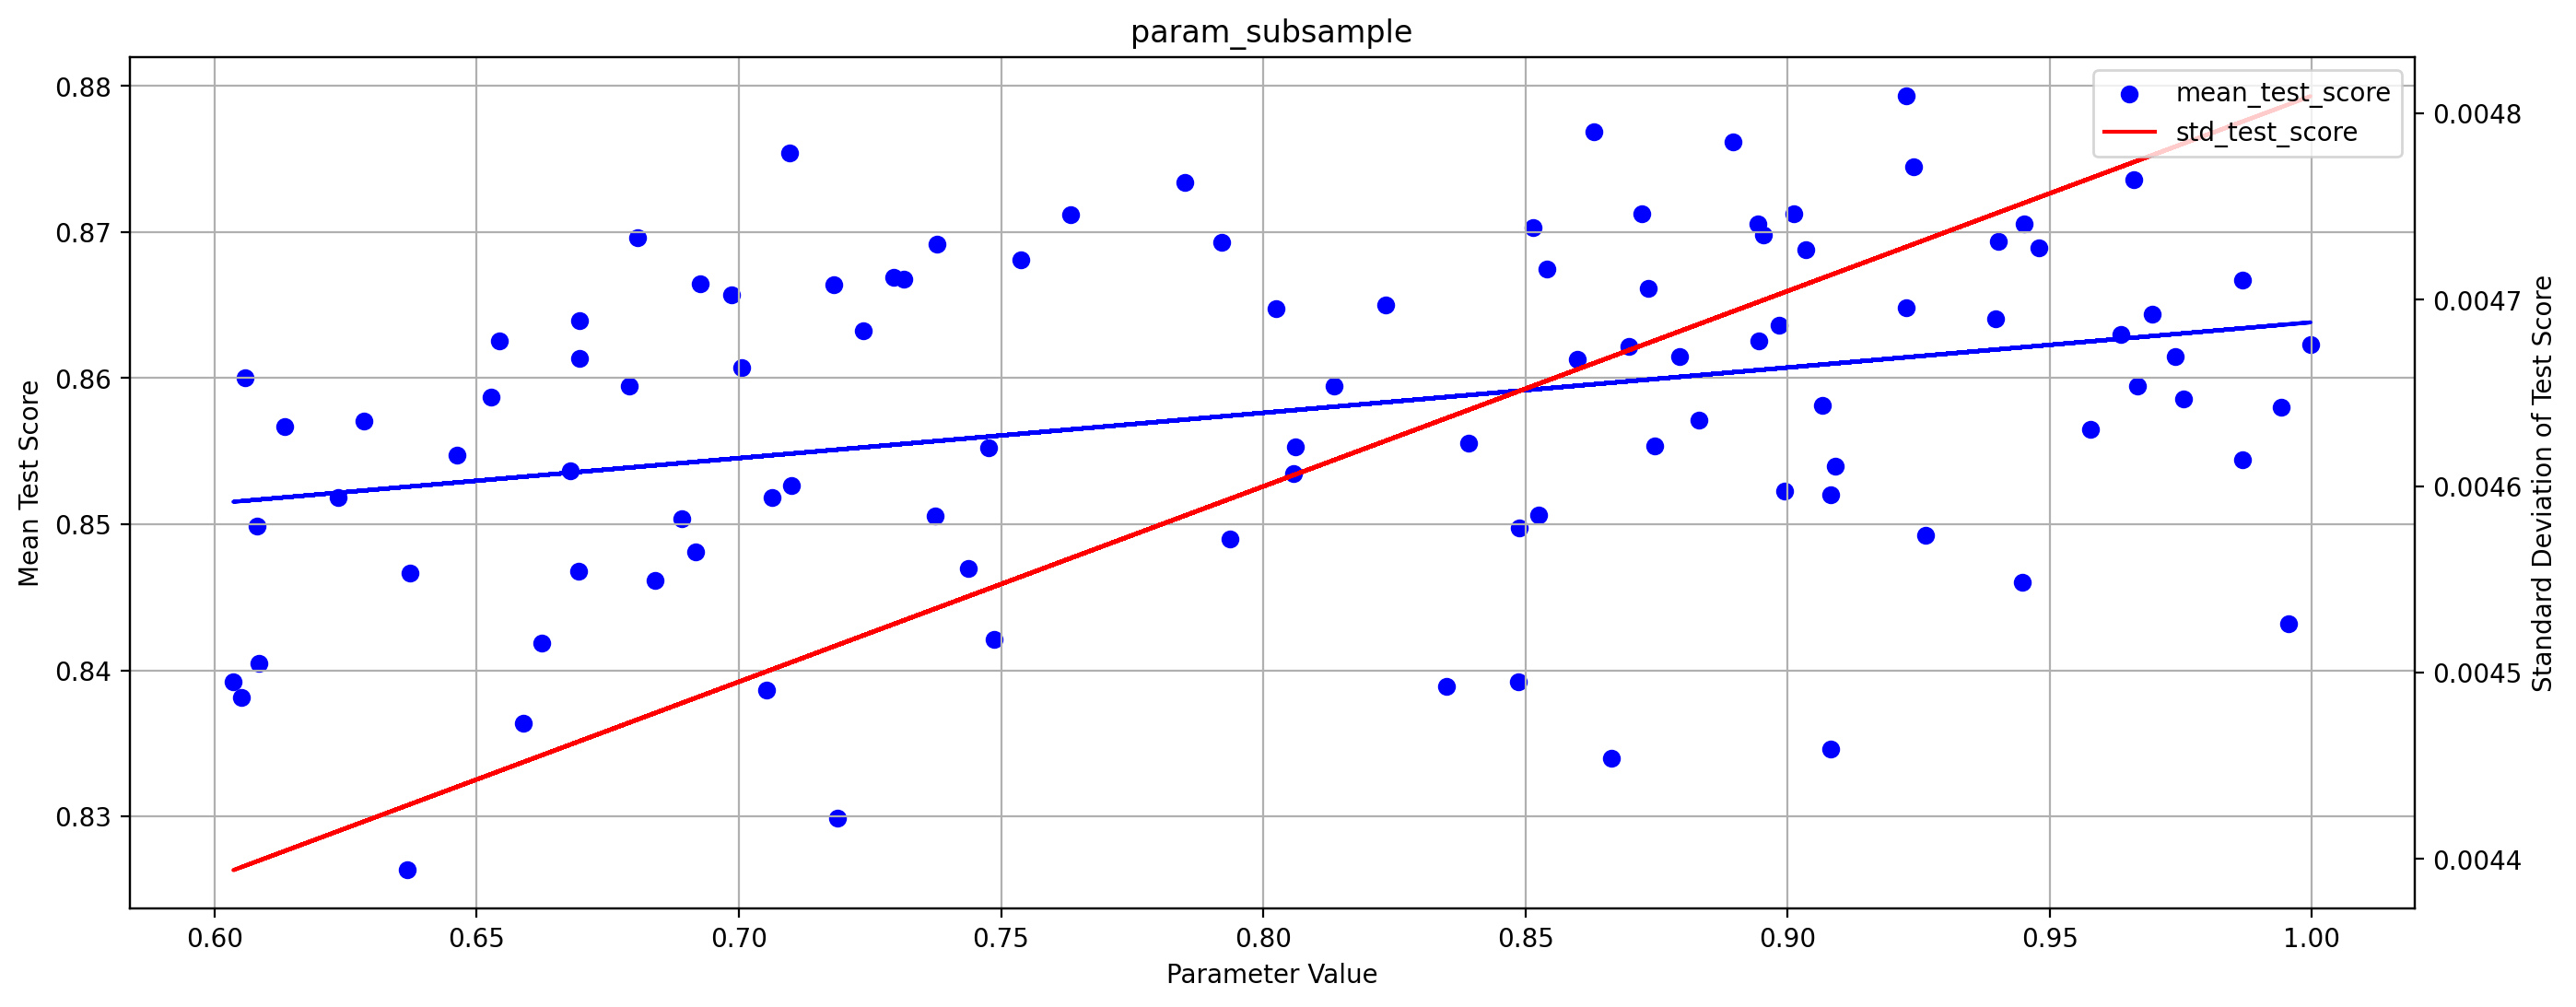

In [27]:
for param in ['param_colsample_bylevel', 'param_colsample_bynode', 'param_colsample_bytree',
                     'param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 
                     'param_reg_alpha', 'param_reg_lambda', 'param_subsample']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


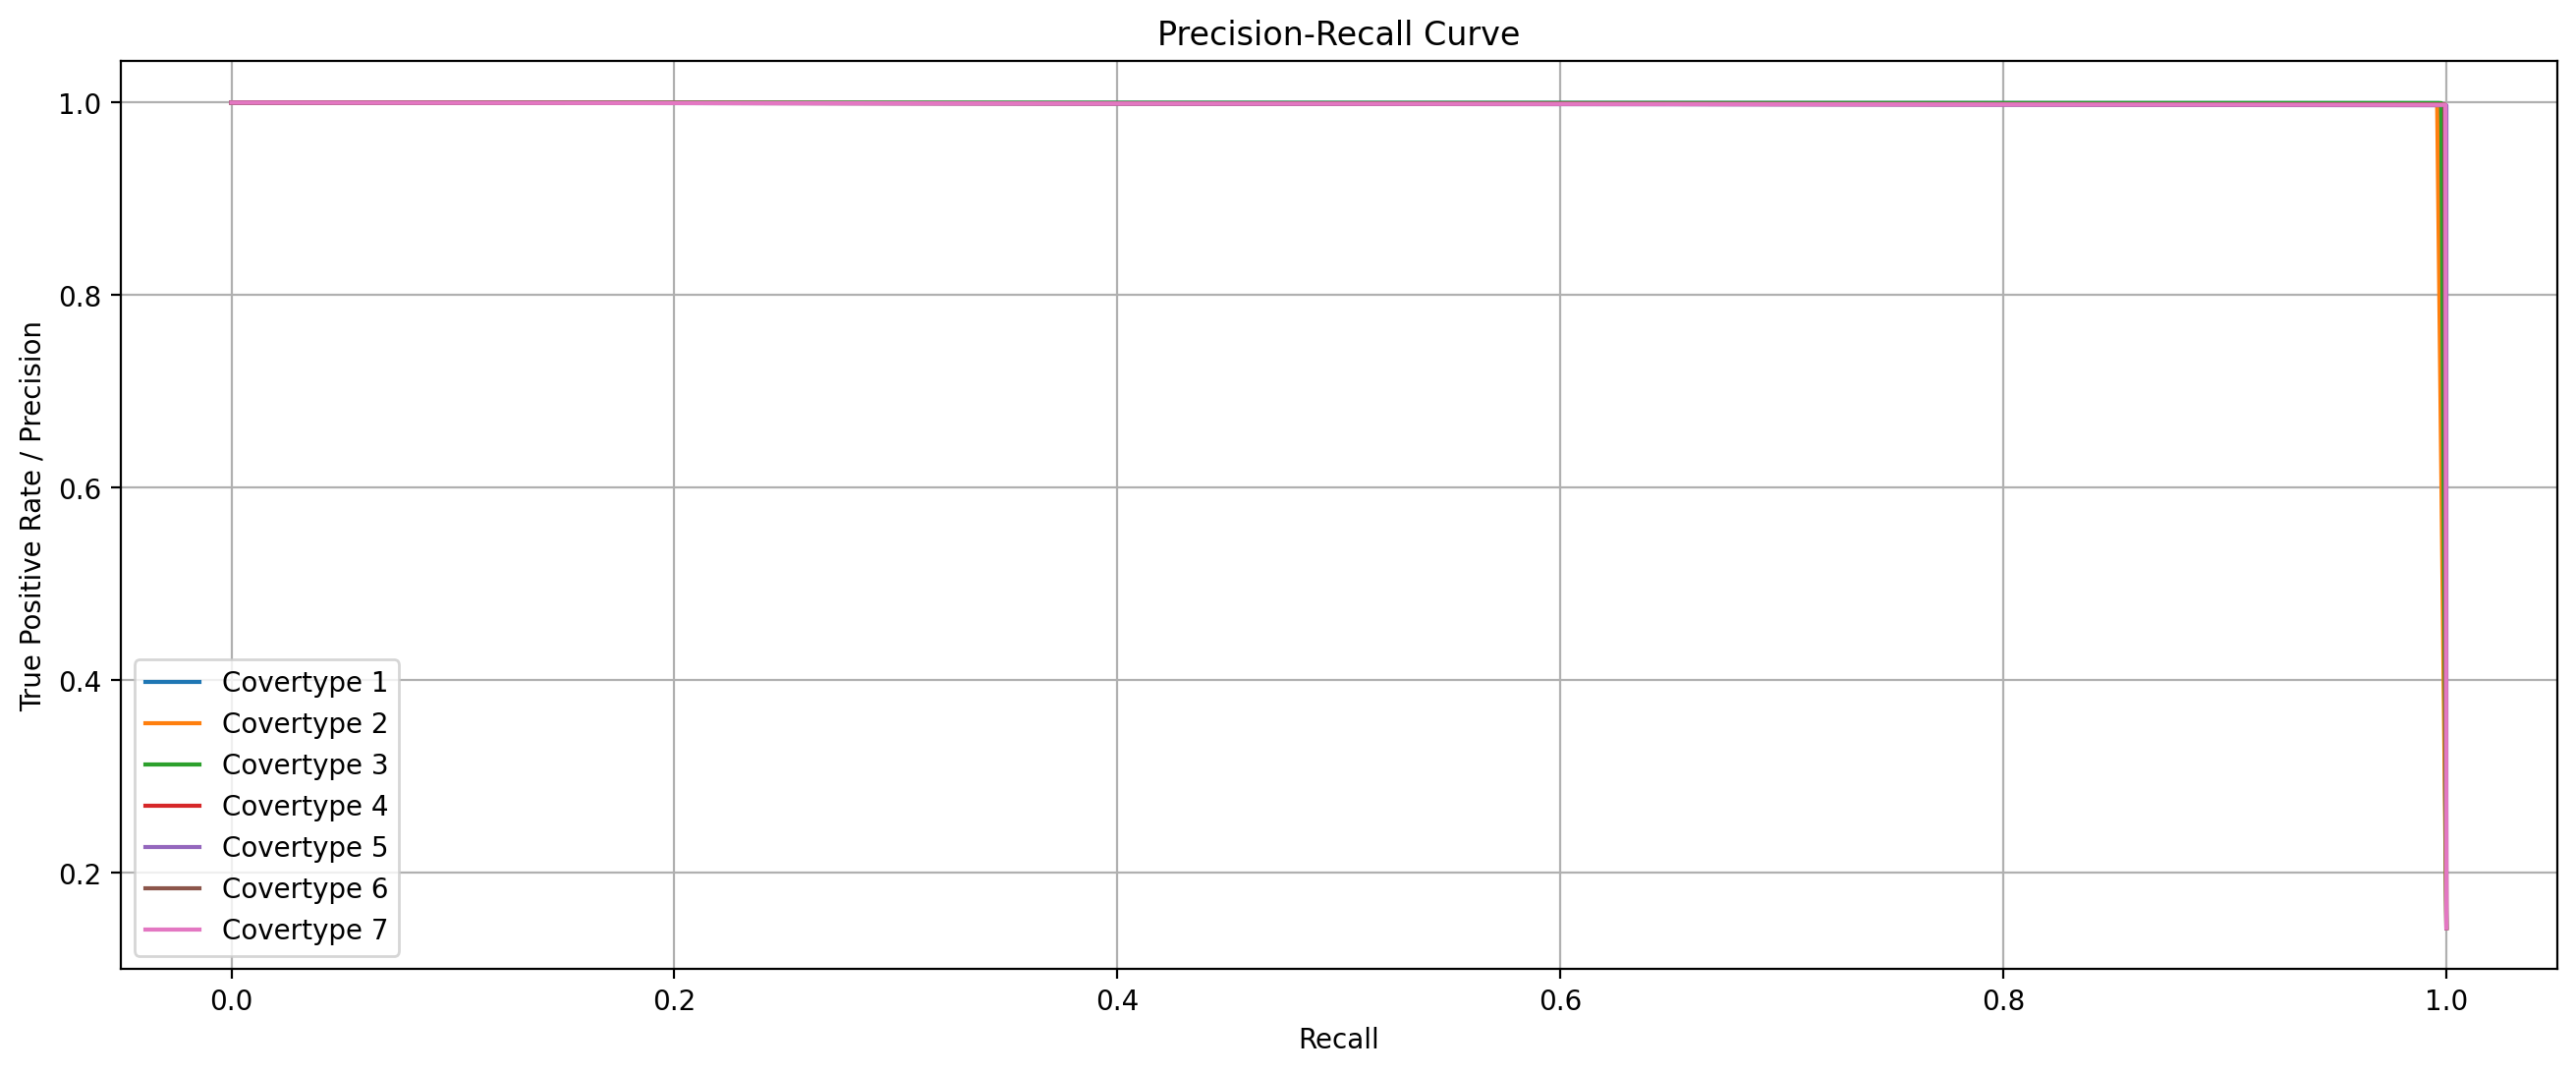

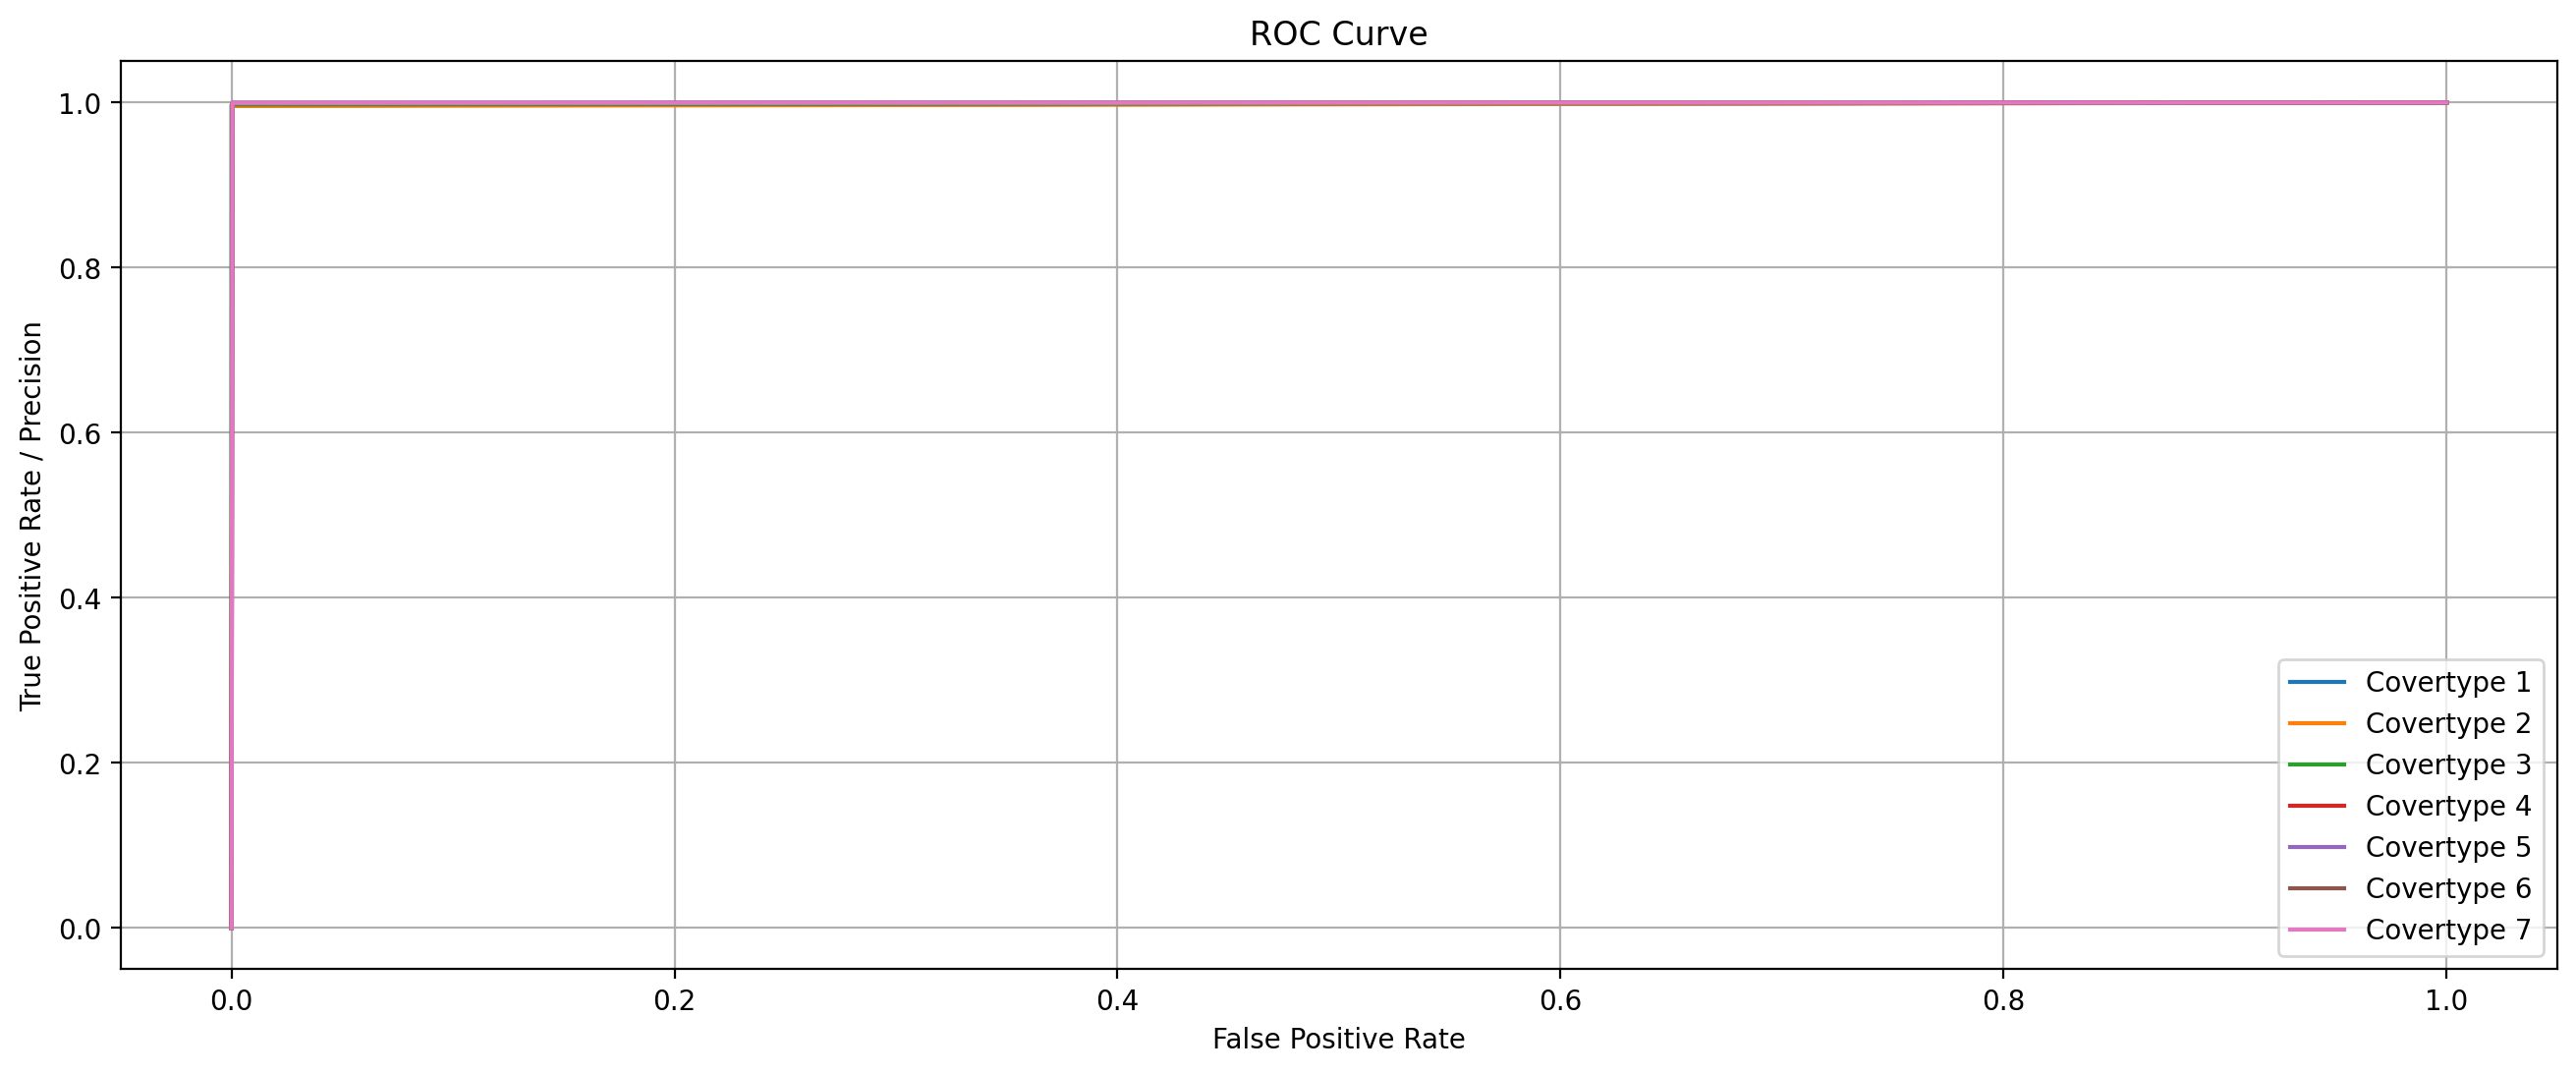

In [28]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_train, classes=np.unique(y_train))
y_score_bin = label_binarize(y_train_prediction, classes=np.unique(y_train_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

classes = len(y_train.unique())

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [29]:
# potentially iterate over features (and relation ie 0 to 1)

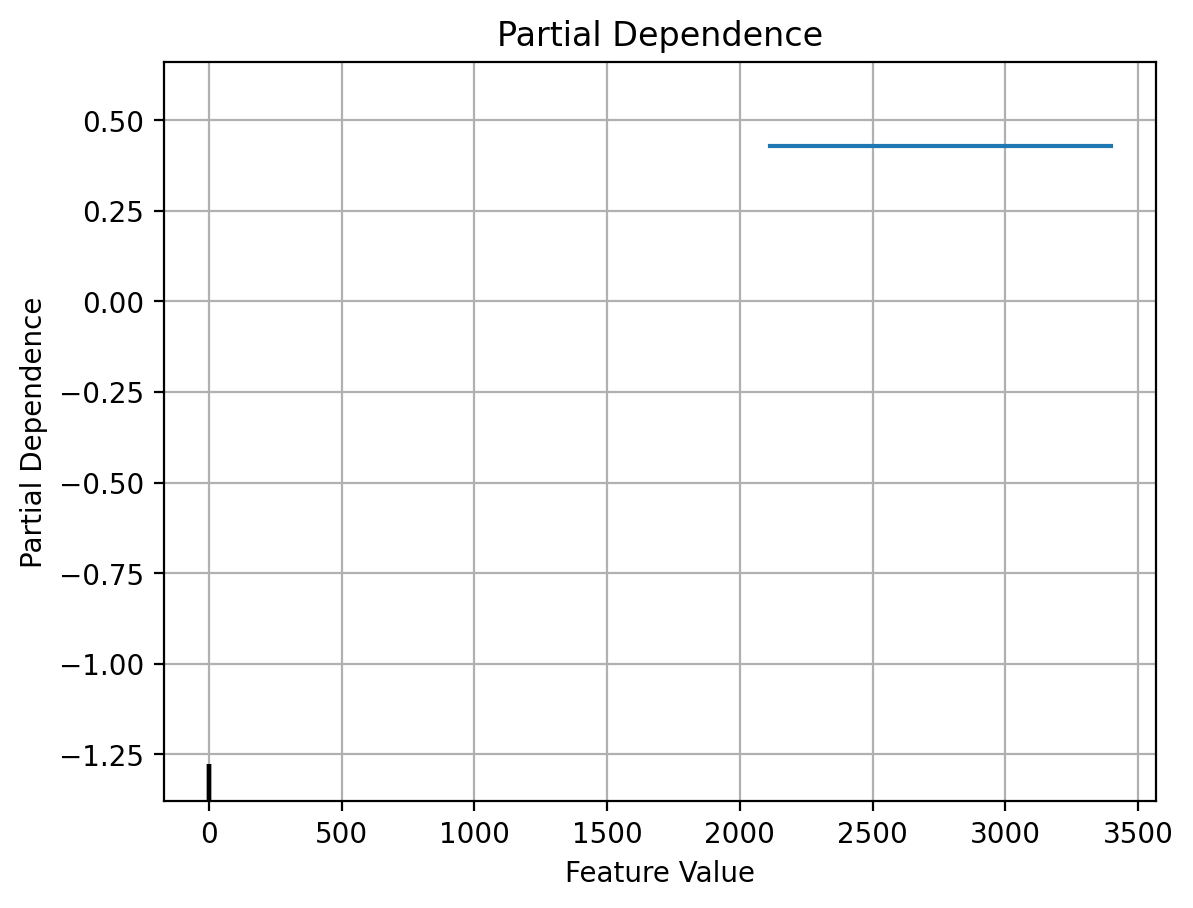

In [30]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

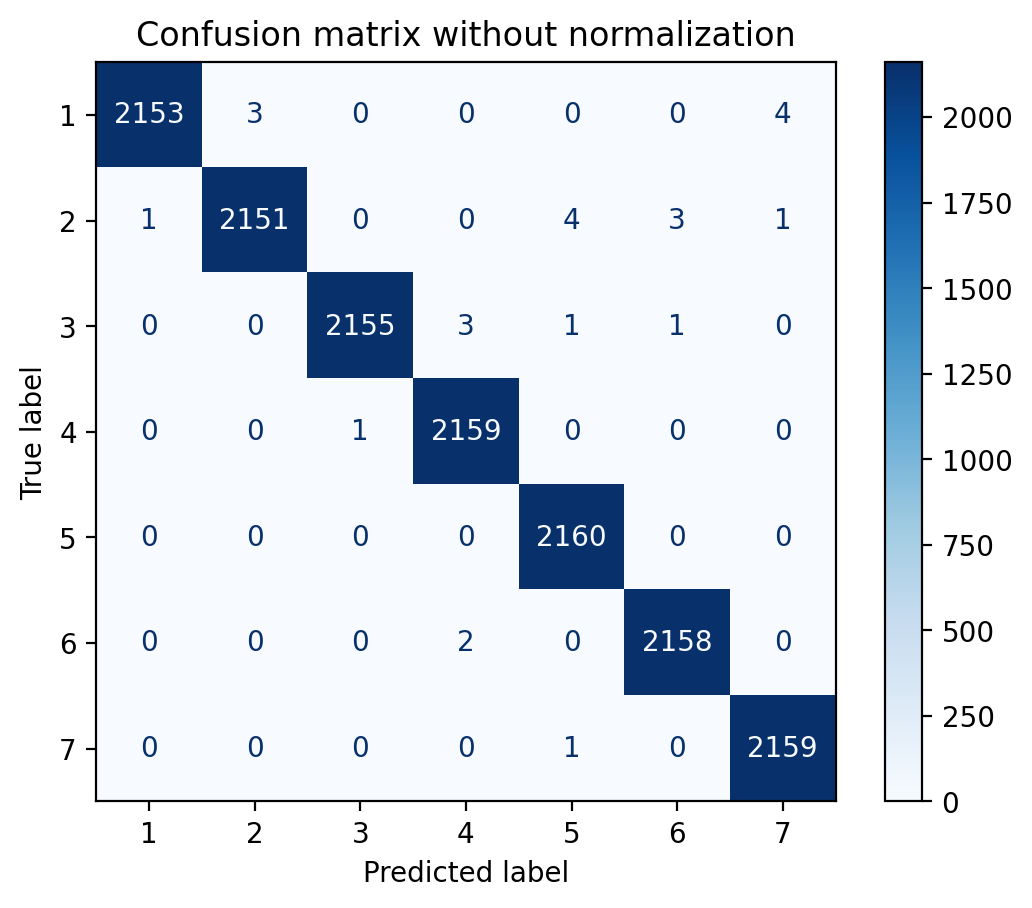

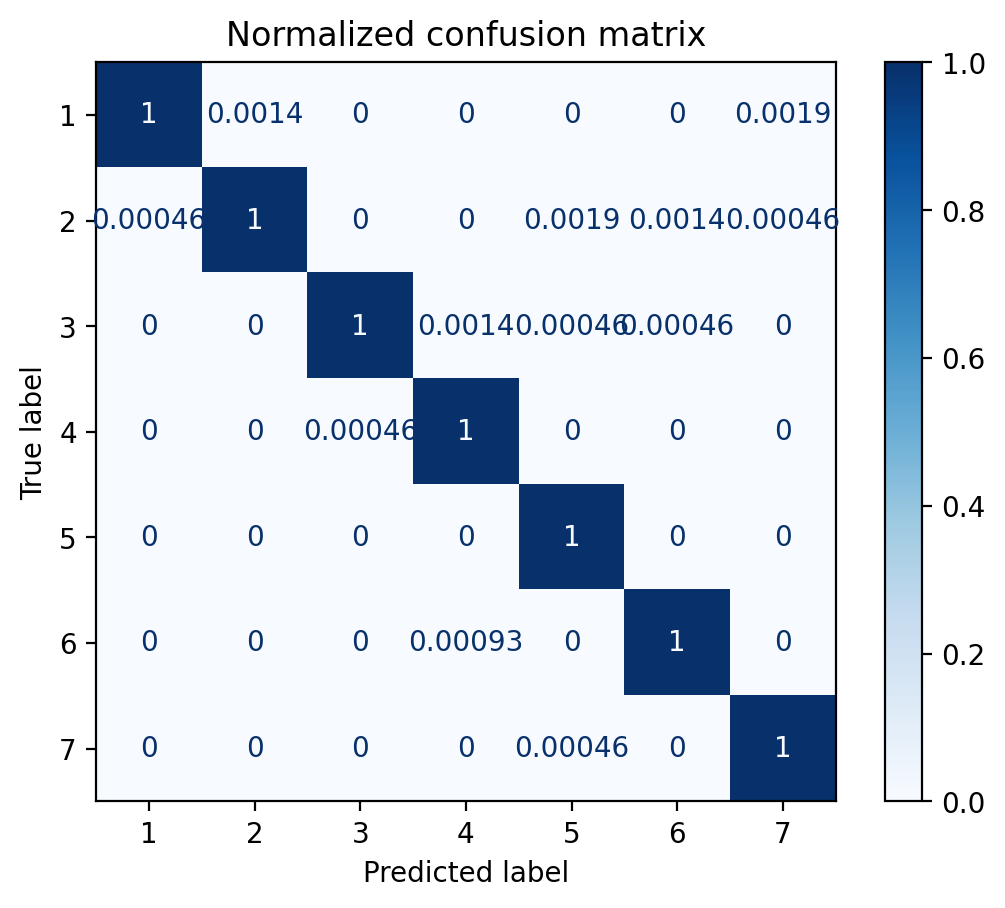

In [31]:

class_names = np.unique(y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_train,
        y_train,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [32]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_train, check_additivity=False)


In [38]:
# Get feature names from X_train
feature_names = X.columns

# Create SHAP summary plot
shap.summary_plot(explanation, X_train, feature_names=feature_names, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.


In [34]:
# IF WE SCALE: SCALE ONLY TRAIN DATA SET
# BOOSTING ALG:

# - Feature Selection: AUTOMATIC (NON CRITICAL)
# - Scaling: AUTOMATIC
# - Handling Missing Values: AUTOMATIC
# - Outliers: NEED TO DEAL WITH

[CV 3/5; 78/100] END colsample_bylevel=0.782357241736422, colsample_bynode=0.6223688001662354, colsample_bytree=0.8344209091955143, gamma=1.2219391008090856, learning_rate=0.050714396461805505, max_depth=30, n_estimators=132, reg_alpha=0.12531913281442297, reg_lambda=0.15633930940410345, subsample=0.6543136162377611;, score=(train=0.964, test=0.859) total time=   6.8s
[CV 1/5; 80/100] START colsample_bylevel=0.6263692745334165, colsample_bynode=0.7731978641914348, colsample_bytree=0.946425218125345, gamma=1.1380421320899028, learning_rate=0.06308635265923954, max_depth=40, n_estimators=117, reg_alpha=1.5903098723728686, reg_lambda=1.8166377182203015, subsample=0.8057630439652899
[CV 1/5; 80/100] END colsample_bylevel=0.6263692745334165, colsample_bynode=0.7731978641914348, colsample_bytree=0.946425218125345, gamma=1.1380421320899028, learning_rate=0.06308635265923954, max_depth=40, n_estimators=117, reg_alpha=1.5903098723728686, reg_lambda=1.8166377182203015, subsample=0.80576304396528

[CV 1/5; 74/100] END colsample_bylevel=0.8292251600376853, colsample_bynode=0.7350139605496702, colsample_bytree=0.7272257279923264, gamma=0.5515119440572875, learning_rate=0.12193103025114009, max_depth=40, n_estimators=135, reg_alpha=1.220753562740732, reg_lambda=1.9835433433438918, subsample=0.8943122561221857;, score=(train=0.973, test=0.868) total time=   5.4s
[CV 5/5; 75/100] START colsample_bylevel=0.9393319449273161, colsample_bynode=0.8107172229261179, colsample_bytree=0.6421442853351461, gamma=0.8728029136410864, learning_rate=0.06538951771893237, max_depth=33, n_estimators=68, reg_alpha=0.01901301189173088, reg_lambda=0.8511291855925014, subsample=0.7920619287617253
[CV 5/5; 75/100] END colsample_bylevel=0.9393319449273161, colsample_bynode=0.8107172229261179, colsample_bytree=0.6421442853351461, gamma=0.8728029136410864, learning_rate=0.06538951771893237, max_depth=33, n_estimators=68, reg_alpha=0.01901301189173088, reg_lambda=0.8511291855925014, subsample=0.792061928761725

[CV 3/5; 79/100] START colsample_bylevel=0.9587885459837938, colsample_bynode=0.6135183492029336, colsample_bytree=0.9004355852584162, gamma=0.33986119820429583, learning_rate=0.05443482638855255, max_depth=44, n_estimators=63, reg_alpha=0.5832089275904535, reg_lambda=0.6921014167966721, subsample=0.6926258780635486
[CV 3/5; 79/100] END colsample_bylevel=0.9587885459837938, colsample_bynode=0.6135183492029336, colsample_bytree=0.9004355852584162, gamma=0.33986119820429583, learning_rate=0.05443482638855255, max_depth=44, n_estimators=63, reg_alpha=0.5832089275904535, reg_lambda=0.6921014167966721, subsample=0.6926258780635486;, score=(train=0.977, test=0.866) total time=   7.9s
[CV 1/5; 81/100] START colsample_bylevel=0.8485855321401488, colsample_bynode=0.8225992900168129, colsample_bytree=0.6675289894826227, gamma=0.25172119046796704, learning_rate=0.08145463255265298, max_depth=28, n_estimators=51, reg_alpha=1.1240530689672774, reg_lambda=0.7999432510338989, subsample=0.903509923877

[CV 5/5; 73/100] START colsample_bylevel=0.9099652967672608, colsample_bynode=0.8846047497489697, colsample_bytree=0.7004650199518271, gamma=1.1364792159875583, learning_rate=0.06545746653019739, max_depth=18, n_estimators=67, reg_alpha=0.10483787474461015, reg_lambda=1.861435523519172, subsample=0.6133989818800097
[CV 5/5; 73/100] END colsample_bylevel=0.9099652967672608, colsample_bynode=0.8846047497489697, colsample_bytree=0.7004650199518271, gamma=1.1364792159875583, learning_rate=0.06545746653019739, max_depth=18, n_estimators=67, reg_alpha=0.10483787474461015, reg_lambda=1.861435523519172, subsample=0.6133989818800097;, score=(train=0.947, test=0.849) total time=   5.0s
[CV 3/5; 75/100] START colsample_bylevel=0.9393319449273161, colsample_bynode=0.8107172229261179, colsample_bytree=0.6421442853351461, gamma=0.8728029136410864, learning_rate=0.06538951771893237, max_depth=33, n_estimators=68, reg_alpha=0.01901301189173088, reg_lambda=0.8511291855925014, subsample=0.79206192876172

[CV 2/5; 71/100] START colsample_bylevel=0.6040089957272272, colsample_bynode=0.9589201677054735, colsample_bytree=0.7199742899188853, gamma=1.2660055932872794, learning_rate=0.14171021440758724, max_depth=45, n_estimators=131, reg_alpha=1.1889064630062294, reg_lambda=0.8279151007503696, subsample=0.6679083712677741
[CV 2/5; 71/100] END colsample_bylevel=0.6040089957272272, colsample_bynode=0.9589201677054735, colsample_bytree=0.7199742899188853, gamma=1.2660055932872794, learning_rate=0.14171021440758724, max_depth=45, n_estimators=131, reg_alpha=1.1889064630062294, reg_lambda=0.8279151007503696, subsample=0.6679083712677741;, score=(train=0.930, test=0.850) total time=   3.6s
[CV 4/5; 72/100] START colsample_bylevel=0.9393553871483633, colsample_bynode=0.7203364877627737, colsample_bytree=0.8336978341030861, gamma=1.3672570887640325, learning_rate=0.12740208992888247, max_depth=35, n_estimators=102, reg_alpha=1.5239961764897512, reg_lambda=0.457297479296463, subsample=0.7101028210571

# XGB Model Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report

In [35]:
from numpy import sort
thresholds = sort(model.feature_importances_)

In [39]:
from sklearn.model_selection import cross_val_score

model_select = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier(**best_params)
    selection_model.fit(select_X_train, y_train)

    scores = cross_val_score(selection_model, select_X_train, y_train, cv=5)
    accuracy = np.mean(scores)

    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    model_select.append([thresh, select_X_train.shape[1], accuracy*100.0])

Thresh=0.000, n=58, Accuracy: 87.93%
Thresh=0.000, n=58, Accuracy: 87.93%
Thresh=0.002, n=56, Accuracy: 87.66%
Thresh=0.002, n=55, Accuracy: 87.96%
Thresh=0.002, n=54, Accuracy: 88.08%
Thresh=0.002, n=53, Accuracy: 88.01%
Thresh=0.002, n=52, Accuracy: 87.87%
Thresh=0.002, n=51, Accuracy: 87.92%
Thresh=0.002, n=50, Accuracy: 87.90%
Thresh=0.003, n=49, Accuracy: 88.12%
Thresh=0.003, n=48, Accuracy: 88.04%
Thresh=0.003, n=47, Accuracy: 88.02%
Thresh=0.003, n=46, Accuracy: 88.06%
Thresh=0.003, n=45, Accuracy: 88.01%
Thresh=0.003, n=44, Accuracy: 87.93%
Thresh=0.003, n=43, Accuracy: 88.19%
Thresh=0.003, n=42, Accuracy: 88.06%
Thresh=0.003, n=41, Accuracy: 88.05%
Thresh=0.003, n=40, Accuracy: 88.13%
Thresh=0.003, n=39, Accuracy: 88.10%
Thresh=0.003, n=38, Accuracy: 88.17%
Thresh=0.003, n=37, Accuracy: 88.27%
Thresh=0.003, n=36, Accuracy: 88.39%
Thresh=0.003, n=35, Accuracy: 88.32%
Thresh=0.004, n=34, Accuracy: 88.40%
Thresh=0.004, n=33, Accuracy: 88.56%
Thresh=0.004, n=32, Accuracy: 88.49%
T

In [42]:
df1 = pd.DataFrame(model_select, columns = ['Threshold', 'Nr of Features', 'Accuracy (%)']) 

import dataframe_image as dfi
dfi.export(df1.round(3), os.path.join(results_path, 'SelectFromModel.png'))


# KAGGLE Prediction

In [43]:
test_processed = pd.read_csv('../../../Data/test_engineered.csv')

In [44]:
test_processed.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  elevation_cubed  \
0            221             232            148  ...      17495004736   
1            220             235            151  ...      17373979000   
2            234             238            135  ...      22046214464   
3            238             238            122  ...      21601086625   
4            220             234            150  ...      17474794875   

   log_elevation  sqrt_elevation  reciprocal_elevation  positive_elevation  \
0       7.861727       50.950957              0.000385                   1   
1       7.859413       50.892043              0.000386                   1   
2       7.938802       52.952809              0.000357                   1   
3       7.932003       52.773099              0.000359                   1   
4       7.861342       50.941143              0.000385                   1   

   negative_elevation  elevation_bin  rolling_mean_elevation  \
0                   0              1                     NaN   
1                   0              1                     NaN   
2                   0              2             2663.333333   
3                   0              2             2726.333333   
4                   0              1             2728.000000   

   extreme_elevation  exp_elevation  
0                  0            inf  
1                  0            inf  
2                  0            inf  
3                  0            inf  
4                  0            inf  

[5 rows x 101 columns]

In [45]:
X_submission = test_processed[['Wilderness_Area3',
 'Hillshade_Noon',
 'elevation_bin',
 'Euclidian_Distance',
 'Horizontal_Distance_To_Roadways',
 'Wilderness_Area4',
 'Vertical_Distance_To_Hydrology',
 'Elevation',
 'sqrt_elevation',
 'subalpine',
 'Wilderness_Area2',
 'Aspect_Sector_NW',
 'Diff_Noon_3pm',
 'igneous_and_metamorphic',
 'montane',
 'alpine',
 'Wilderness_Area1',
 'log_elevation',
 'reciprocal_elevation',
 'Horizontal_Distance_To_Fire_Points',
 'elevation_squared',
 'montane_and_subalpine',
 'elevation_cubed',
 'glacial',
 'lower_montane',
 'Id',
 'Hillshade_9am',
 'Horizontal_Distance_To_Hydrology']]

X_submission = scaler.transform(X_submission)

In [46]:
y_kaggle = model.predict(X_submission) + 1

In [47]:
pd.read_csv("../../../Data/Kaggle/full_submission.csv").head()

Id  Cover_Type
0   1           5
1   2           5
2   3           5
3   4           4
4   5           5

In [48]:
test_processed['Cover_Type'] = y_kaggle

In [49]:
kaggle_submission = test_processed.loc[:, ['Id', 'Cover_Type']]

In [50]:
kaggle_submission.Cover_Type.value_counts()

Cover_Type
2    247540
1    211129
3     37386
7     30590
5     26610
6     23859
4      3898
Name: count, dtype: int64

In [52]:
kaggle_submission.to_csv(f'../../../Data/kaggle_submission_{timestamp}.csv', index=False)

In [54]:
pd.read_csv(f'../../../Data/kaggle_submission_{timestamp}.csv')

Id  Cover_Type
0            1           5
1            2           5
2            3           2
3            4           5
4            5           5
...        ...         ...
581007  581008           3
581008  581009           3
581009  581010           3
581010  581011           3
581011  581012           3

[581012 rows x 2 columns]

In [2]:
timestamp = '202403201655'